# MC-Analyzer Example Notebook

<center><table>
<tr>
<td><b><a href="https://github.com/l-althueser">Lutz Althüser</a></b></td>
<td><b>Updated 20/02/2017</b></td>
</tr>
</table></center>

This notebook is a collection of examples for the [MC-Analyzer](https://github.com/l-althueser/MC-Analyzer).

<hr>

# Table of Contents
1. [Installation Prerequisites](#installation_prerequisites)  
1. [Get the Code from GitHub](#get_code)  
1. [Use the MC-Analyzer](#use)  
1. [optPhot S1 analysis](#s1)  
1. [optPhot S2 analysis](#s2)  
1. [parameter variations](#parameter_variations)  
1. [Data maps](#data_maps)  
1. [Comparison of MC vs. data map](#comparison)  
1. [Matching MC vs. data maps](#matching)
1. [Calibration sources](#calibration)

<hr>

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<center><table>
<tr>
<td><b><a href="javascript:code_toggle()">code cells on/off</a></b></td>
</tr>
</table></center>''')

<hr><a id='installation_prerequisites'></a>
# Installation Prerequisites

A [Anaconda3](https://www.continuum.io/downloads) installation with [ROOT 6](https://root.cern.ch/)/[pyROOT](https://root.cern.ch/pyroot) is needed to run this notebook. Alternatively a [pax](https://github.com/XENON1T/pax) environment can be used. The scripts can also be executed with a normal [ROOT 6](https://root.cern.ch/) installation in the C++ way if nothing of the previous options a valid choice.

<hr><a id='get_code'></a>
# Get the Code from GitHub

The code used in this notebook can be downloaded with:
```
git clone https://github.com/l-althueser/MC-Analyzer
```

<hr>
## Import all needed libaries and define some useful functions

In [1]:
notebook_name = 'MC-Analyzer_example'
dir_save_plot = './'+notebook_name

import sys
nb_stdout = sys.stdout
import os
cur_dir = os.getcwd()
sub_dir = '/'.join(os.getcwd().split('/')[:-1])

import ROOT
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML, Javascript

import collections
binning = collections.namedtuple('Bins', 'z r rr')

import logging
logging.getLogger('rootpy.stl').setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

sys.stdout = nb_stdout
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)
canvas_x = 1920
canvas_y = 1080

# center plots in output
CSS = """
.output_png img {
    display: block;
    margin-left: auto;
    margin-right: auto;
}
"""
HTML('<style>{}</style>'.format(CSS))

display(HTML("<style>.container { width:80% !important; }</style>"))

if not os.path.exists(dir_save_plot):
    os.makedirs(dir_save_plot)

def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

# use `output_HTML(notebook_name)` to save as HTML
def output_HTML(read_file):
    save_notebook()
    time.sleep(3)
    if Path(read_file+'.ipynb').is_file():
        print('Save notebook to: '+read_file+'_<date>.html')
        os.system('jupyter nbconvert --to html '+read_file+'.ipynb')
        os.system('mv '+read_file+'.html '+read_file+'_$(date +"%Y%m%d-%H%M%S").html')

print('Initialized with notebook name: ' + notebook_name)

def show(images, title='', align='row'):
    "This function shows given png files (or generate them first from a ROOT.TCanvas)"
    if type(images) is ROOT.TCanvas:
        images.SaveAs(dir_save_plot+'/'+images.GetName()+'.png');
        images = [dir_save_plot+'/'+images.GetName()+'.png']
        nb_images = len(images)
    elif type(images) is str:
        images = [images]
        nb_images = len(images)
    elif type(images) is list: 
        nb_images = len(images)
        for i in range(nb_images):
            if type(images[i]) is ROOT.TCanvas:
                images[i].SaveAs(dir_save_plot+'/'+images[i].GetName()+'.png');
                images[i] = dir_save_plot+'/'+images[i].GetName()+'.png'
            elif type(images[i]) is not str:
                raise TypeError('Only "ROOT.TCanvas" and "str" or lists of both are supported.')
    else:
        raise TypeError('Only "ROOT.TCanvas" and "str" or lists of both are supported.')

    if align == 'row':
        fig = plt.figure(figsize = (60,24))
        for i in range(nb_images):
            fig.add_subplot(1,nb_images,i+1)
            image = mpimg.imread(images[i])
            plt.imshow(image)
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.suptitle(title, fontsize=100)
    elif align == 'column':
        for img in images:
            display(Image(img))
    else:
        raise ValueError('Align value """'+align+'""" is not supported.')
        
def remove_compiled(path):
    for root, dirs, files in os.walk(path):
        for currentFile in files:
            exts = ('.pcm', '.d')
            if any(currentFile.lower().endswith(ext) for ext in exts):
                #print('Remove: '+currentFile)
                os.remove(os.path.join(root, currentFile))

Initialized with notebook name: MC-Analyzer_example


In [38]:
# This is for intercepting the output of ROOT
# In a cell, put %%rootprint so that the output that would normally be
# sent directly to the stdout will instead be displayed in the cell.
# It must be the first element in the cell.
import tempfile
from IPython.core.magic import (Magics, magics_class, cell_magic)

@magics_class
class RootMagics(Magics):
    """Magics related to Root.

    %%rootprint  - Capture Root stdout output and show in result cell
    """

    def __init__(self, shell):
        super(RootMagics, self).__init__(shell)

    @cell_magic
    def rootprint(self, line, cell):
        """Capture Root stdout output and print in ipython notebook."""

        with tempfile.NamedTemporaryFile(mode='w+', newline='\n') as tmpFile:
            ROOT.gSystem.RedirectOutput(tmpFile.name, "w")
            # ns = {}
            # exec cell in self.shell.user_ns, ns
            exec(cell) in self.shell.user_ns
            ROOT.gROOT.ProcessLine("gSystem->RedirectOutput(0);")
            print(tmpFile.read())

# Register
ip = get_ipython()
ip.register_magics(RootMagics)

Quick example of the `Show()` function which can be used to save and show ROOT plots in an easy way (even if the ROOT inline output is not working):

In [ ]:
c_example = ROOT.TCanvas('example_canvas_save_name', 'Example Canvas',
                         canvas_x, canvas_y)
f_example = ROOT.TF1('f_example', 'abs(sin(x)/x)', 0, 15)
f_example.Draw()
show(c_example)

<hr><a id='use'></a>
# Use the MC-Analyzer

The MC-Analyzer can be used with a local ROOT installation. Therefore just `cd` to the top dir and type:
```
root
.x MC-Analyzer.cc+
```
Alternatively you can use a jupyter notebook and follow the given instructions.

In case of any ROOT error during the execution in this notebook do one of the following options:
* Restart the Kernel and reload all cells (or reload first cell which has the `%reset` magic)
* `%reset_selective` the Kernel variables and assign again all variables (check with `who_ls`)

**You have to restart the Kernel if the code of a previous used macro has changed!** (Maybe I will find the reason for this ..)

In [17]:
ROOT.gROOT.Reset()
ROOT.gROOT.ProcessLine('gROOT->Reset();')
remove_compiled('../')

<hr><a id='S1'></a>
# optPhot S1 analysis

You can choose from the following output files (`*.png`) or load the `*_S1.root` file for more plots:  

| vs. | xy | rrZ |    
|----|----|----|  
| `*_S1_LCErr.png` | `*_S1_xy_LCE.png`        | `*_S1_rrZ_gen.png`        |  
| `*_S1_LCEz.png`  | `*_S1_xy_LCE_top.png`    | `*_S1_rrZ_det.png`        |  
| `*_S1_rLCEz.png` | `*_S1_xy_LCE_bottom.png` | `*_S1_rrZ_det_top.png`    |  
|                  |                          | `*_S1_rrZ_det_bottom.png` |    
|                  |                          | `*_S1_rrZ_LCE.png`        |  
|                  |                          | `*_S1_rrZ_LCE_top.png`    |  
|                  |                          | `*_S1_rrZ_LCE_bottom.png` |   
|                  |                          | `*_S1_rrZ_rLCE.png`       |  
|                  |                          | `*_S1_rrZ_rLCE_top.png`   |  
|                  |                          | `*_S1_rrZ_rLCE_bottom.png`|  
|                  |                          | `*_S1_rrZ_rLCE_3D.png`    |  

```
void optPhot_S1(string datafile, string export_format);
void optPhot_S1(string datafile, int bin_z, int bin_r, int bin_rr, string export_format, bool batch);
```

= reading datafile ===== single file =======================
 file: MC_MS_TPC_optPhot_S1_1e5.root 100000 events 
brary /mnt/c/L_Althueser/Repo_Git/MC-Analyzer/examples/./../src/optPhot_S1_cc.so
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_xy_LCE.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_xy_LCE_top.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_xy_LCE_bottom.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_rrZ_gen.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_rrZ_det.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_rrZ_det_top.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5_S1_rrZ_det_bottom.png has been created
Info in <TCanvas::Print>: png file ./MC_MS_TPC/MC_MS_TPC_op

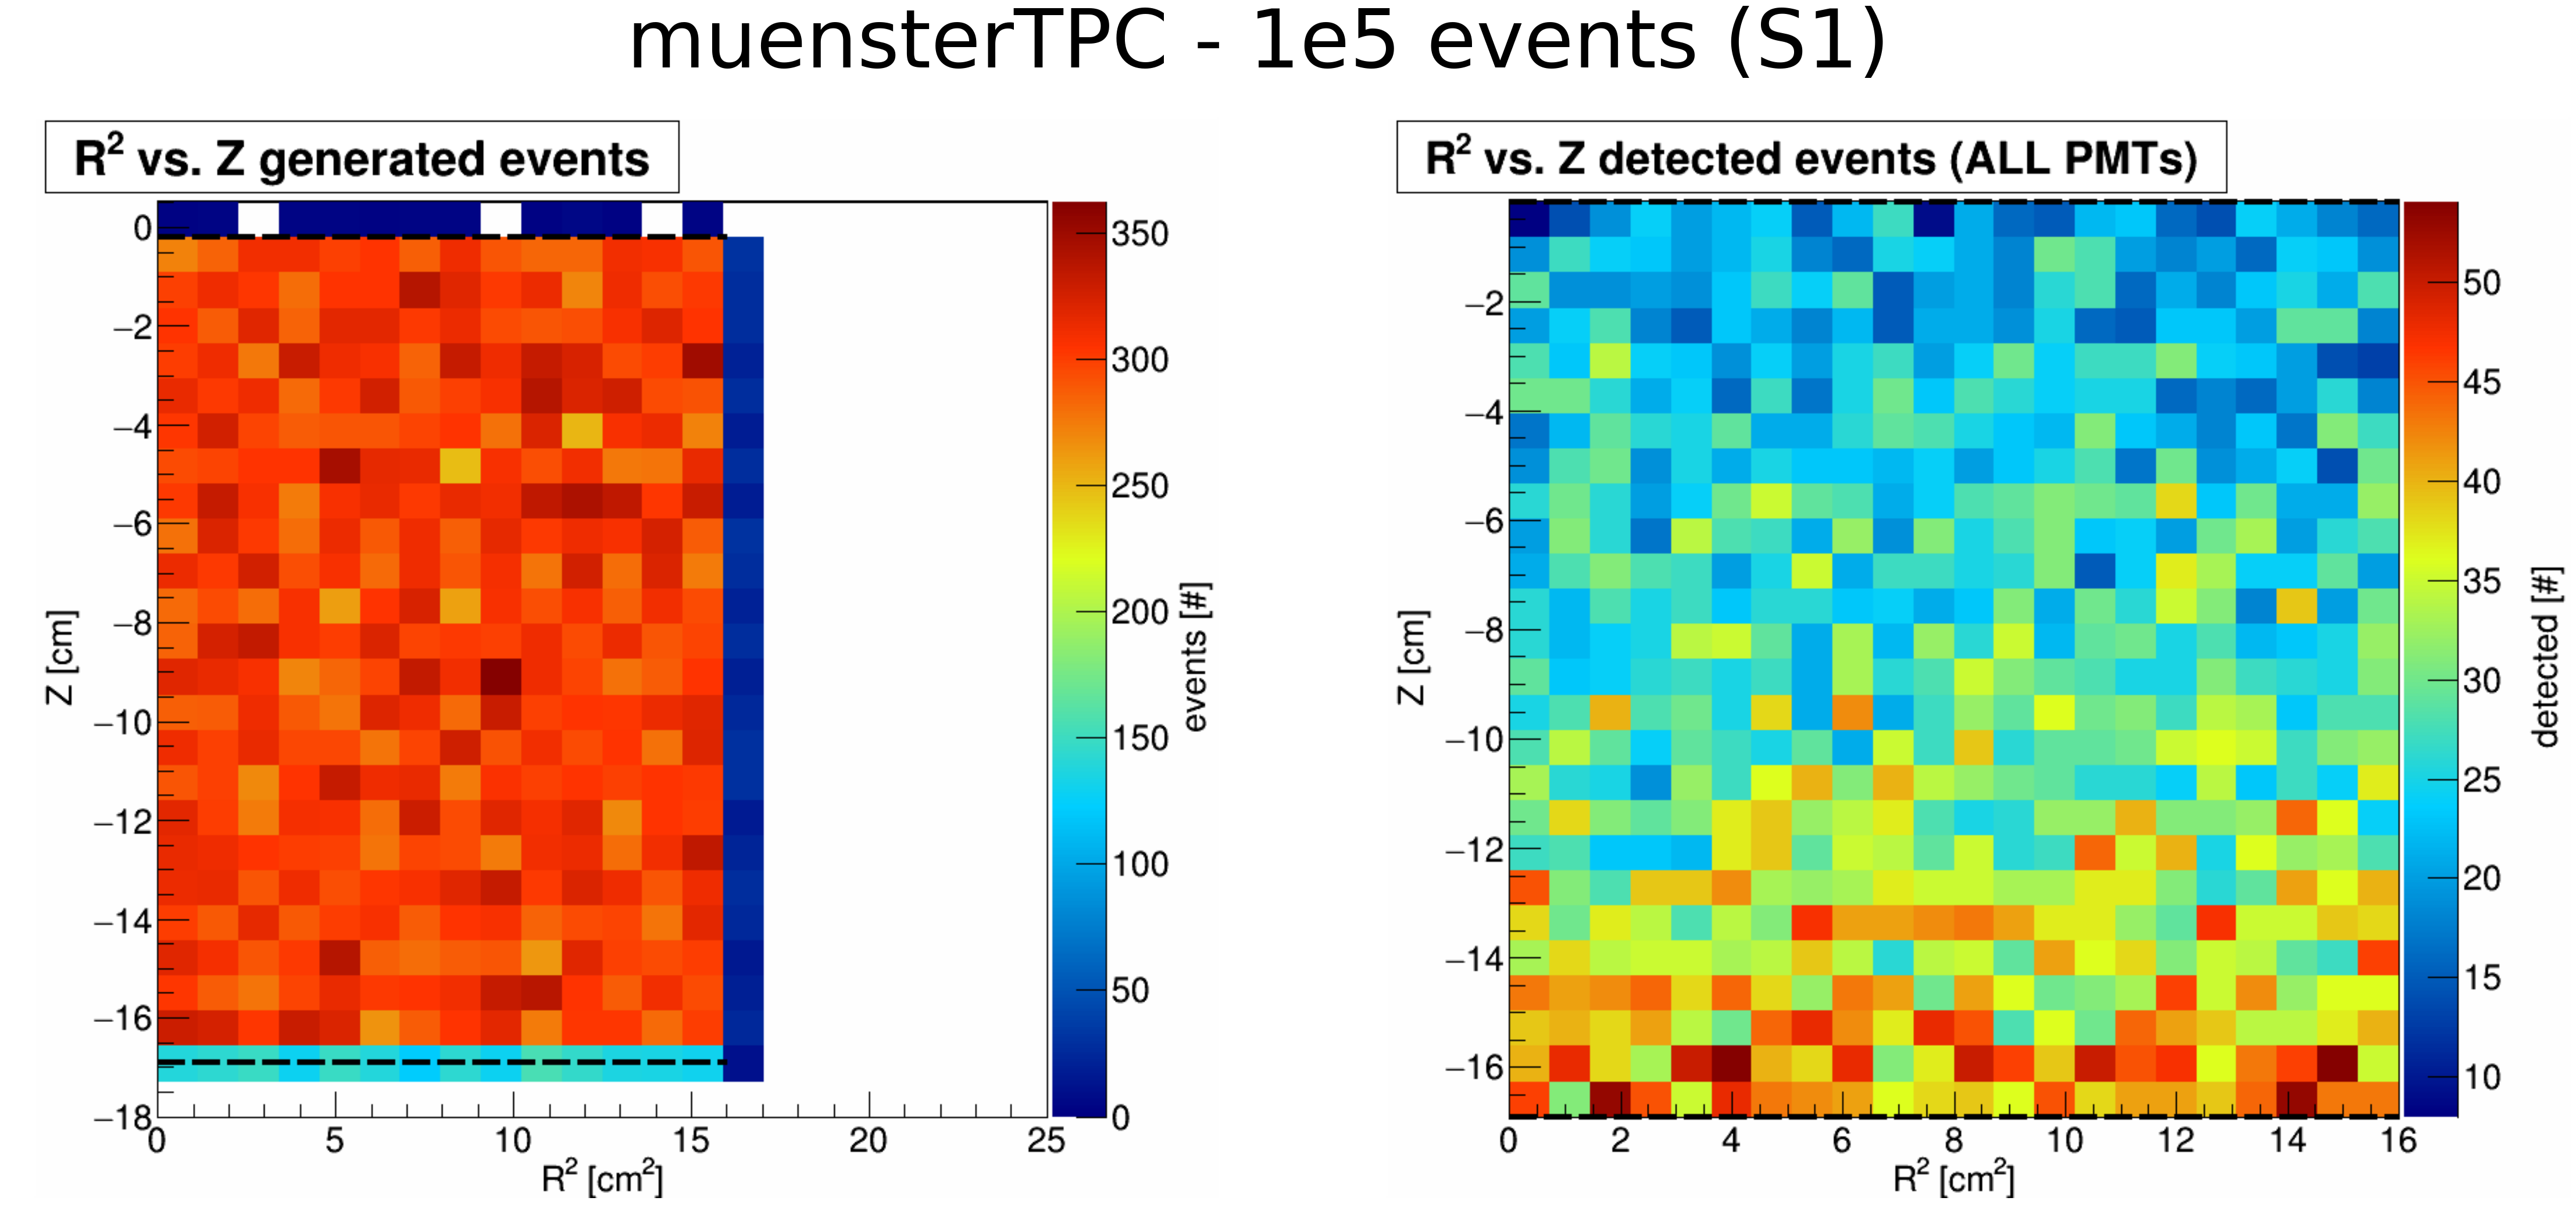

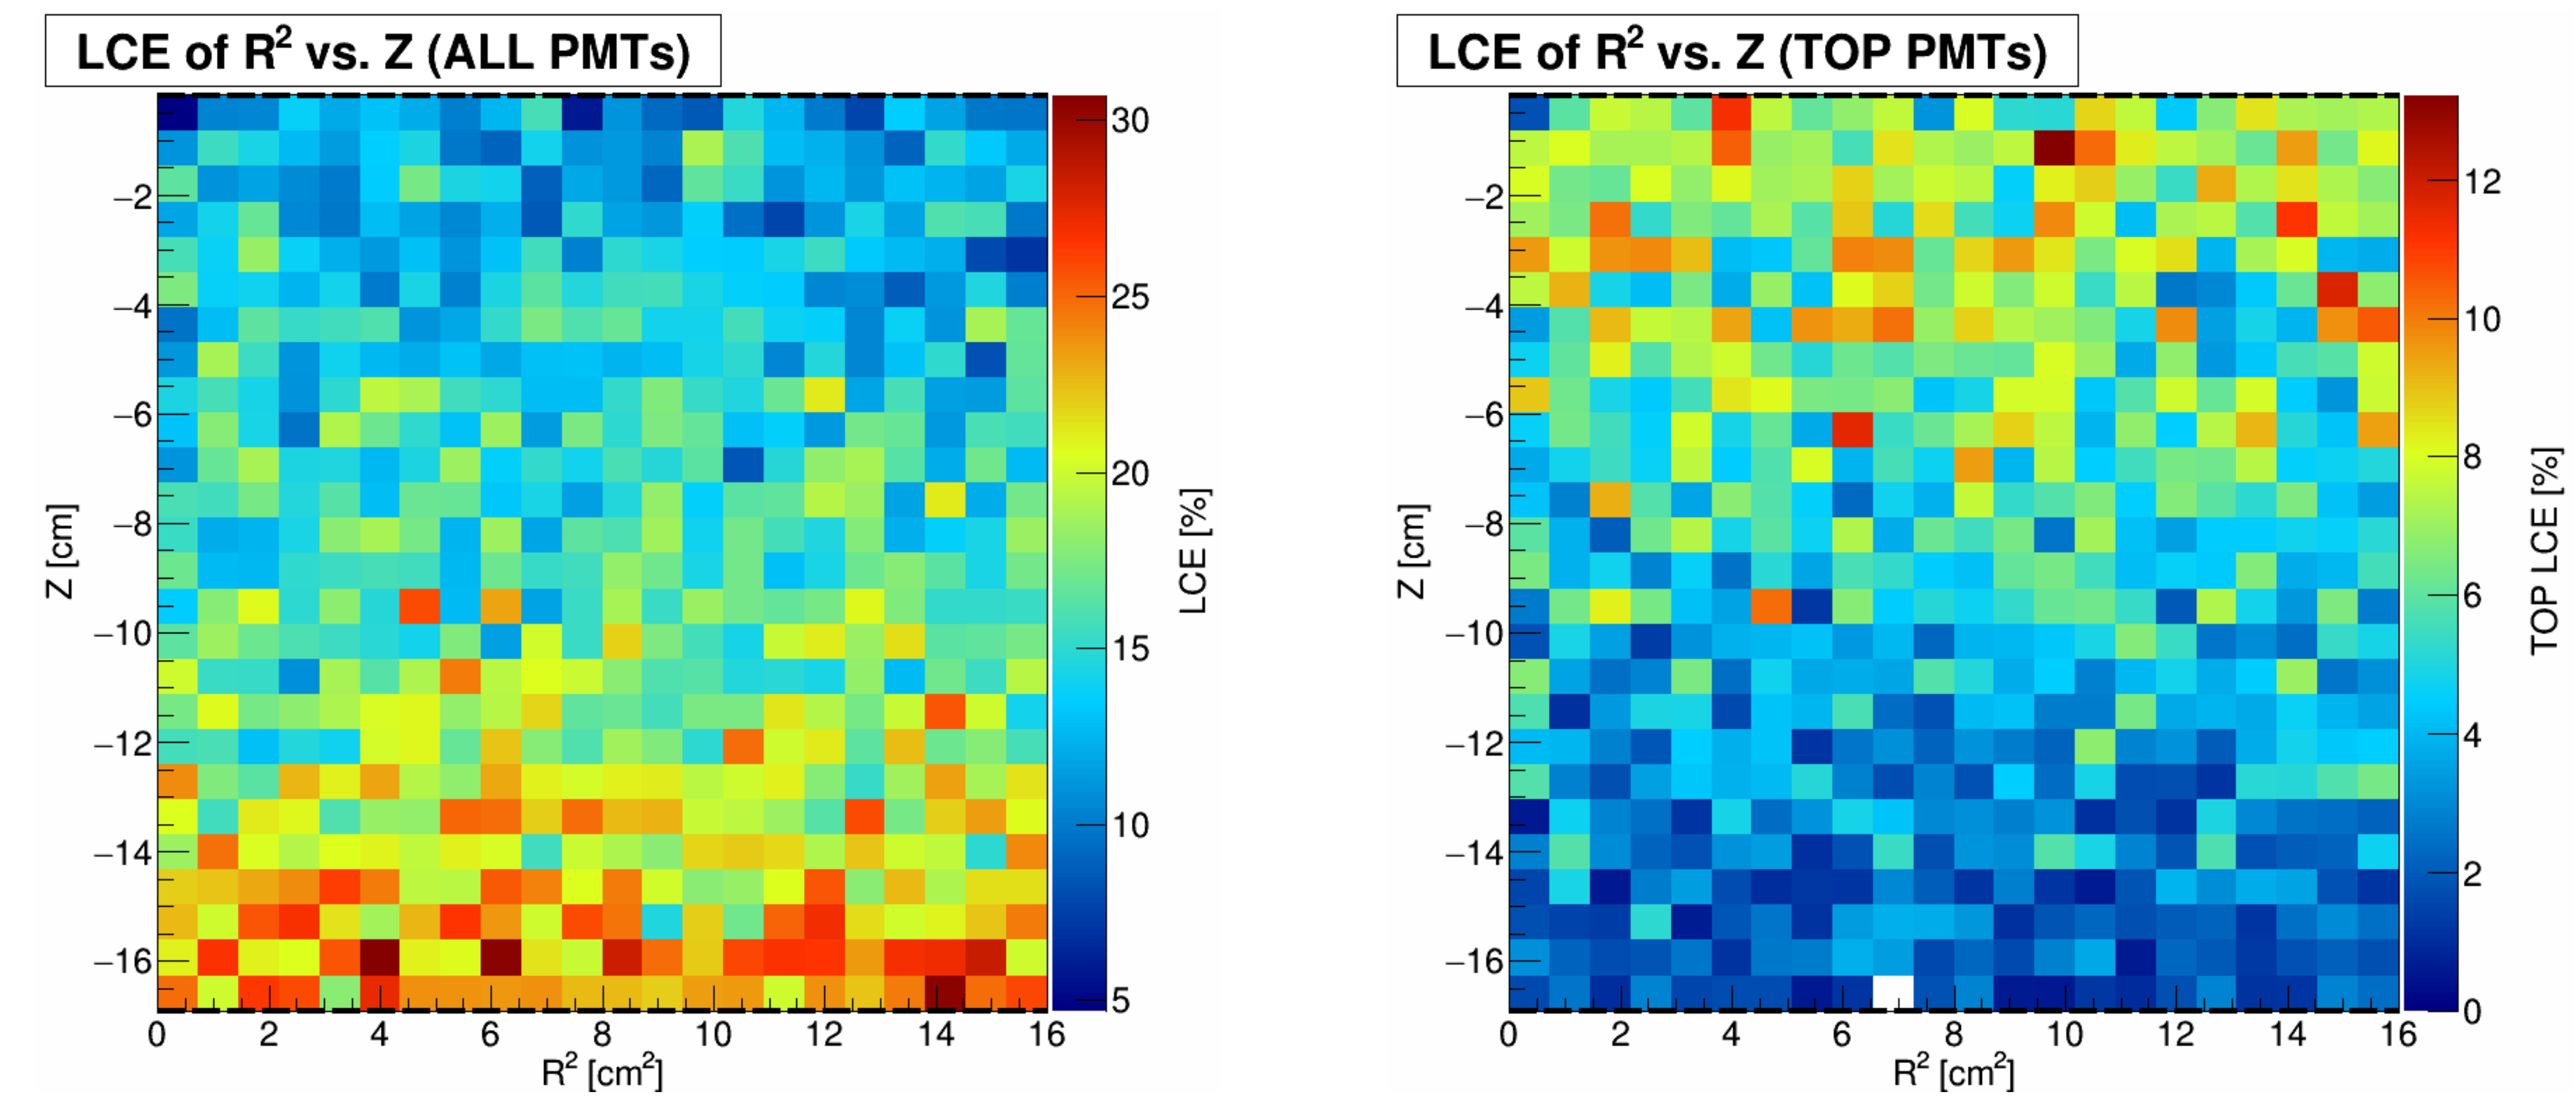

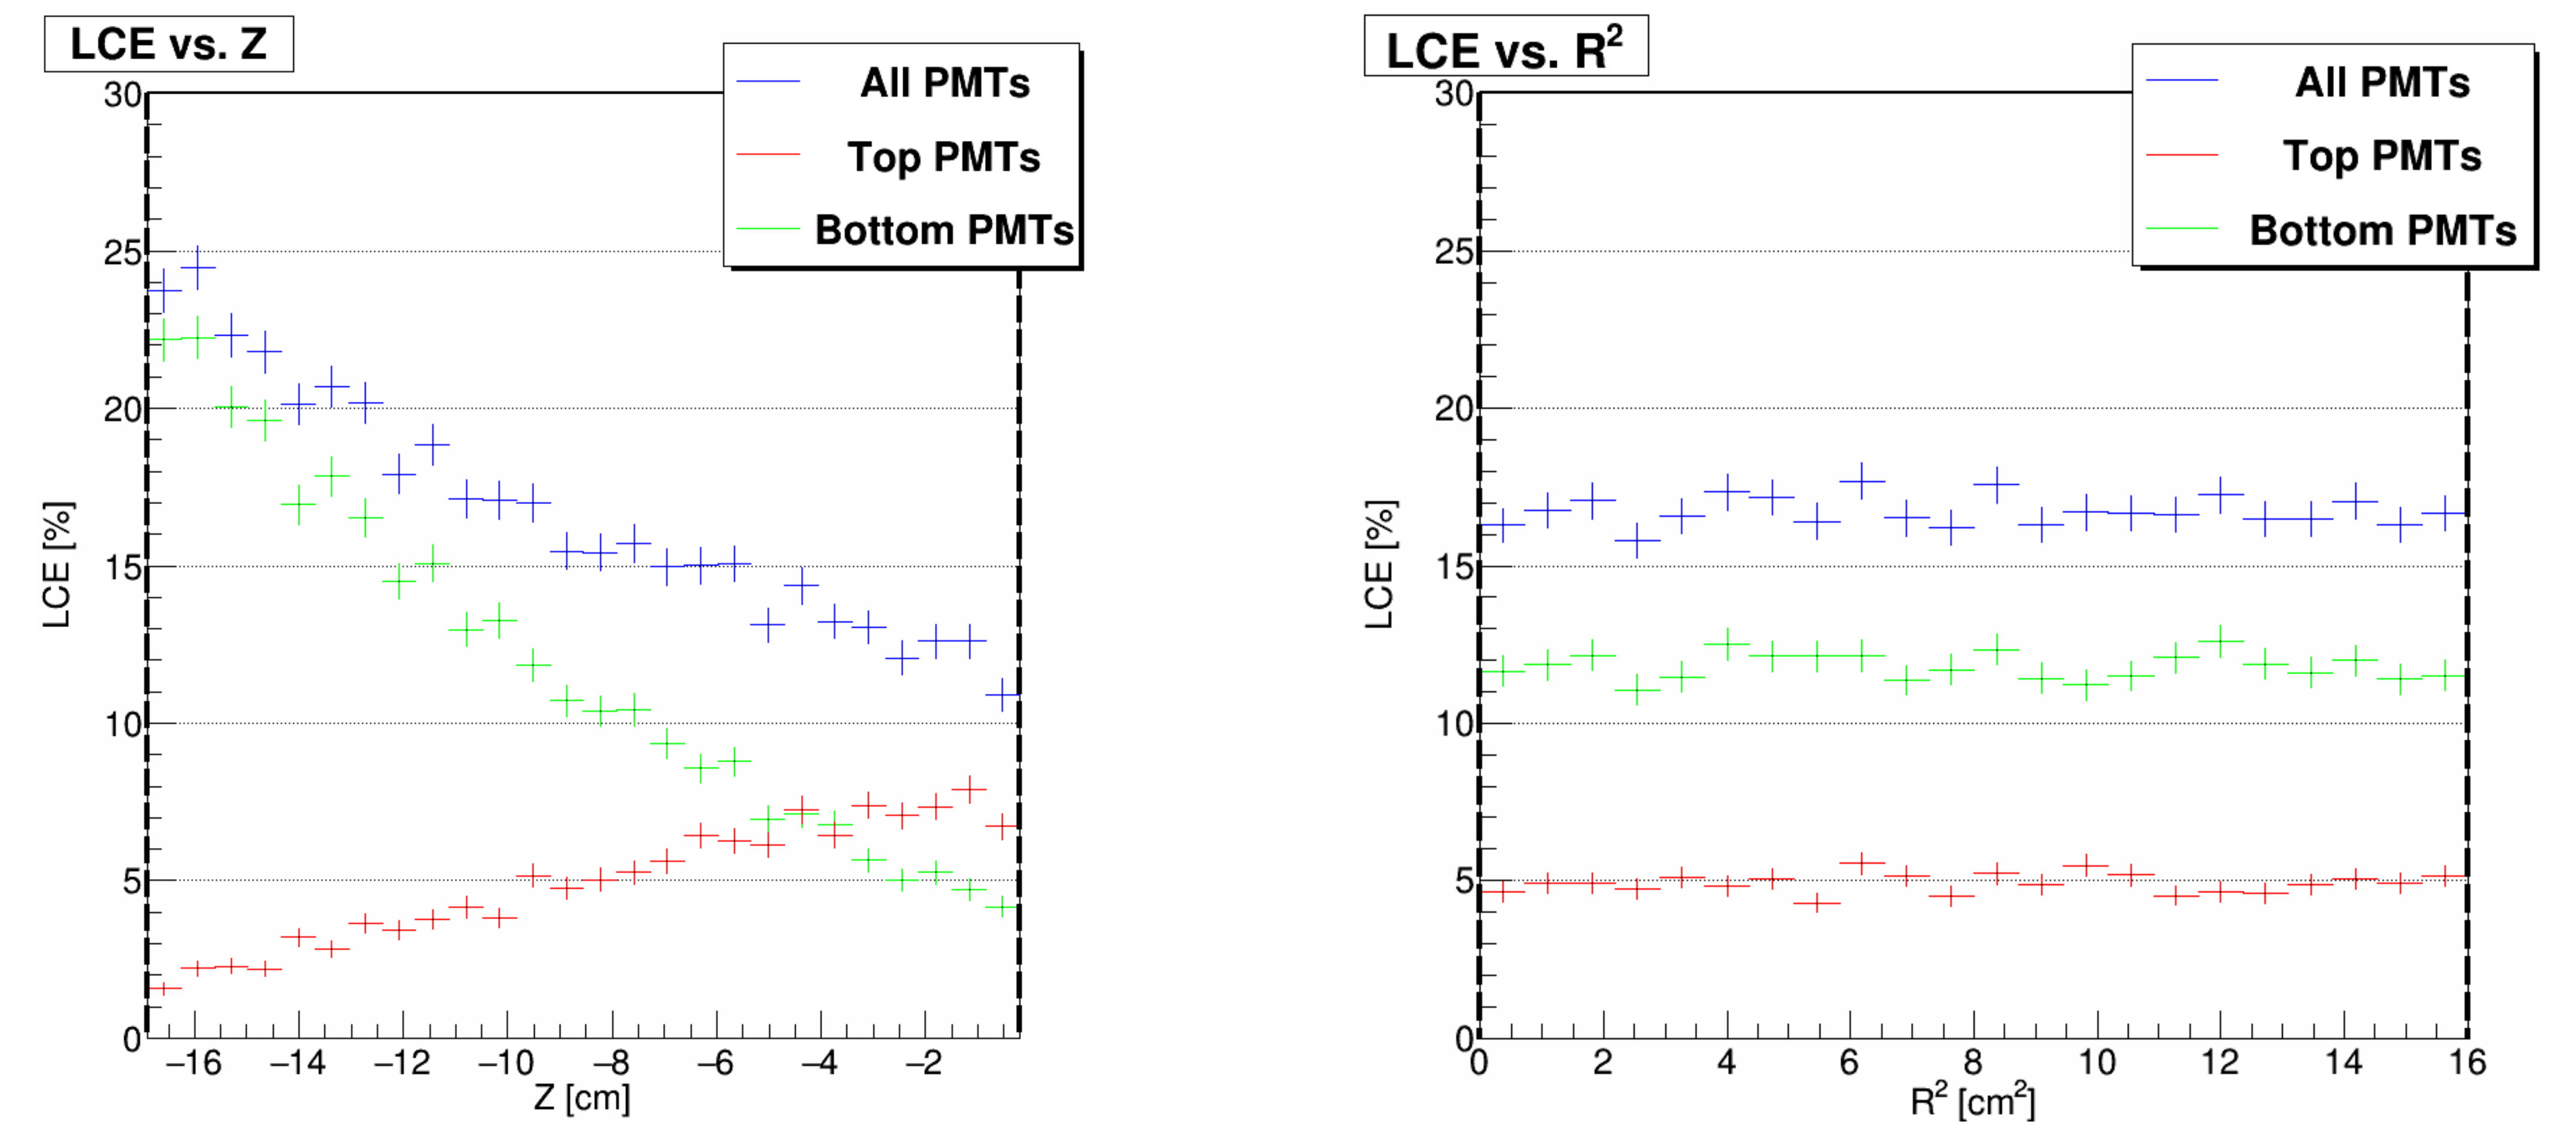

In [41]:
%%rootprint
MC_file = './MC_MS_TPC/MC_MS_TPC_optPhot_S1_1e5.root'
bins = binning('26', '50', '22')
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_S1.cc++("'+MC_file+'",'+bins.z+','+bins.r+','+bins.rr+')')
show([MC_file[:-5]+'_S1_rrZ_gen.png',MC_file[:-5]+'_S1_rrZ_det.png'], 'muensterTPC - 1e5 events (S1)')
show([MC_file[:-5]+'_S1_rrZ_LCE.png',MC_file[:-5]+'_S1_rrZ_LCE_top.png'])
show([MC_file[:-5]+'_S1_LCEz.png',MC_file[:-5]+'_S1_LCErr.png'])

Show the plotting log file:

In [50]:
S1_log = open(MC_file[:-5]+'_S1.dat', 'r')
S1_log_contents = S1_log.read()
print (S1_log_contents)
S1_log.close()

= reading datafile ===== single file =======================
 file: MC_MS_TPC_optPhot_S1_1e5.root 100000 events 
= geometry parameters ======================================
binning: 26 50 22
chamber_minZ: -18
chamber_maxZ: 0.5
chamber_minRR: 0
chamber_maxRR: 25
LXe_minZ: -16.9
LXe_maxZ: -0.2
LXe_minRR: 0
LXe_maxRR: 16
nbinsZ: 26
nbinsRR: 22
LCE_min: 0
LCE_max: 30
= analyse ttree ============================================
generated events: 100000
generated events (LXe): 100000
detected events (LXe): 16724
Mean LCE LXe(detected/generated): 16.724
------------------------------------------------------------
detected events (LXe TOP): 4921
Mean LCE LXe(detected TOP/generated): 4.921
AreaFractionTop LXe(detected TOP/detected ALL): 29.4248
------------------------------------------------------------
detected events (LXe BOTTOM): 11803
Mean LCE LXe(detected BOTTOM/generated): 11.803
AreaFractionBottom LXe(detected BOTTOM/detected ALL): 70.5752
= plot xy ====================================

<hr><a id='S2'></a>
# optPhot S2 analysis

```
void optPhot_S2(string datafile, string export_format);
void optPhot_S2(string datafile, int bin_z, int bin_r, int bin_rr, string export_format, bool batch);
```

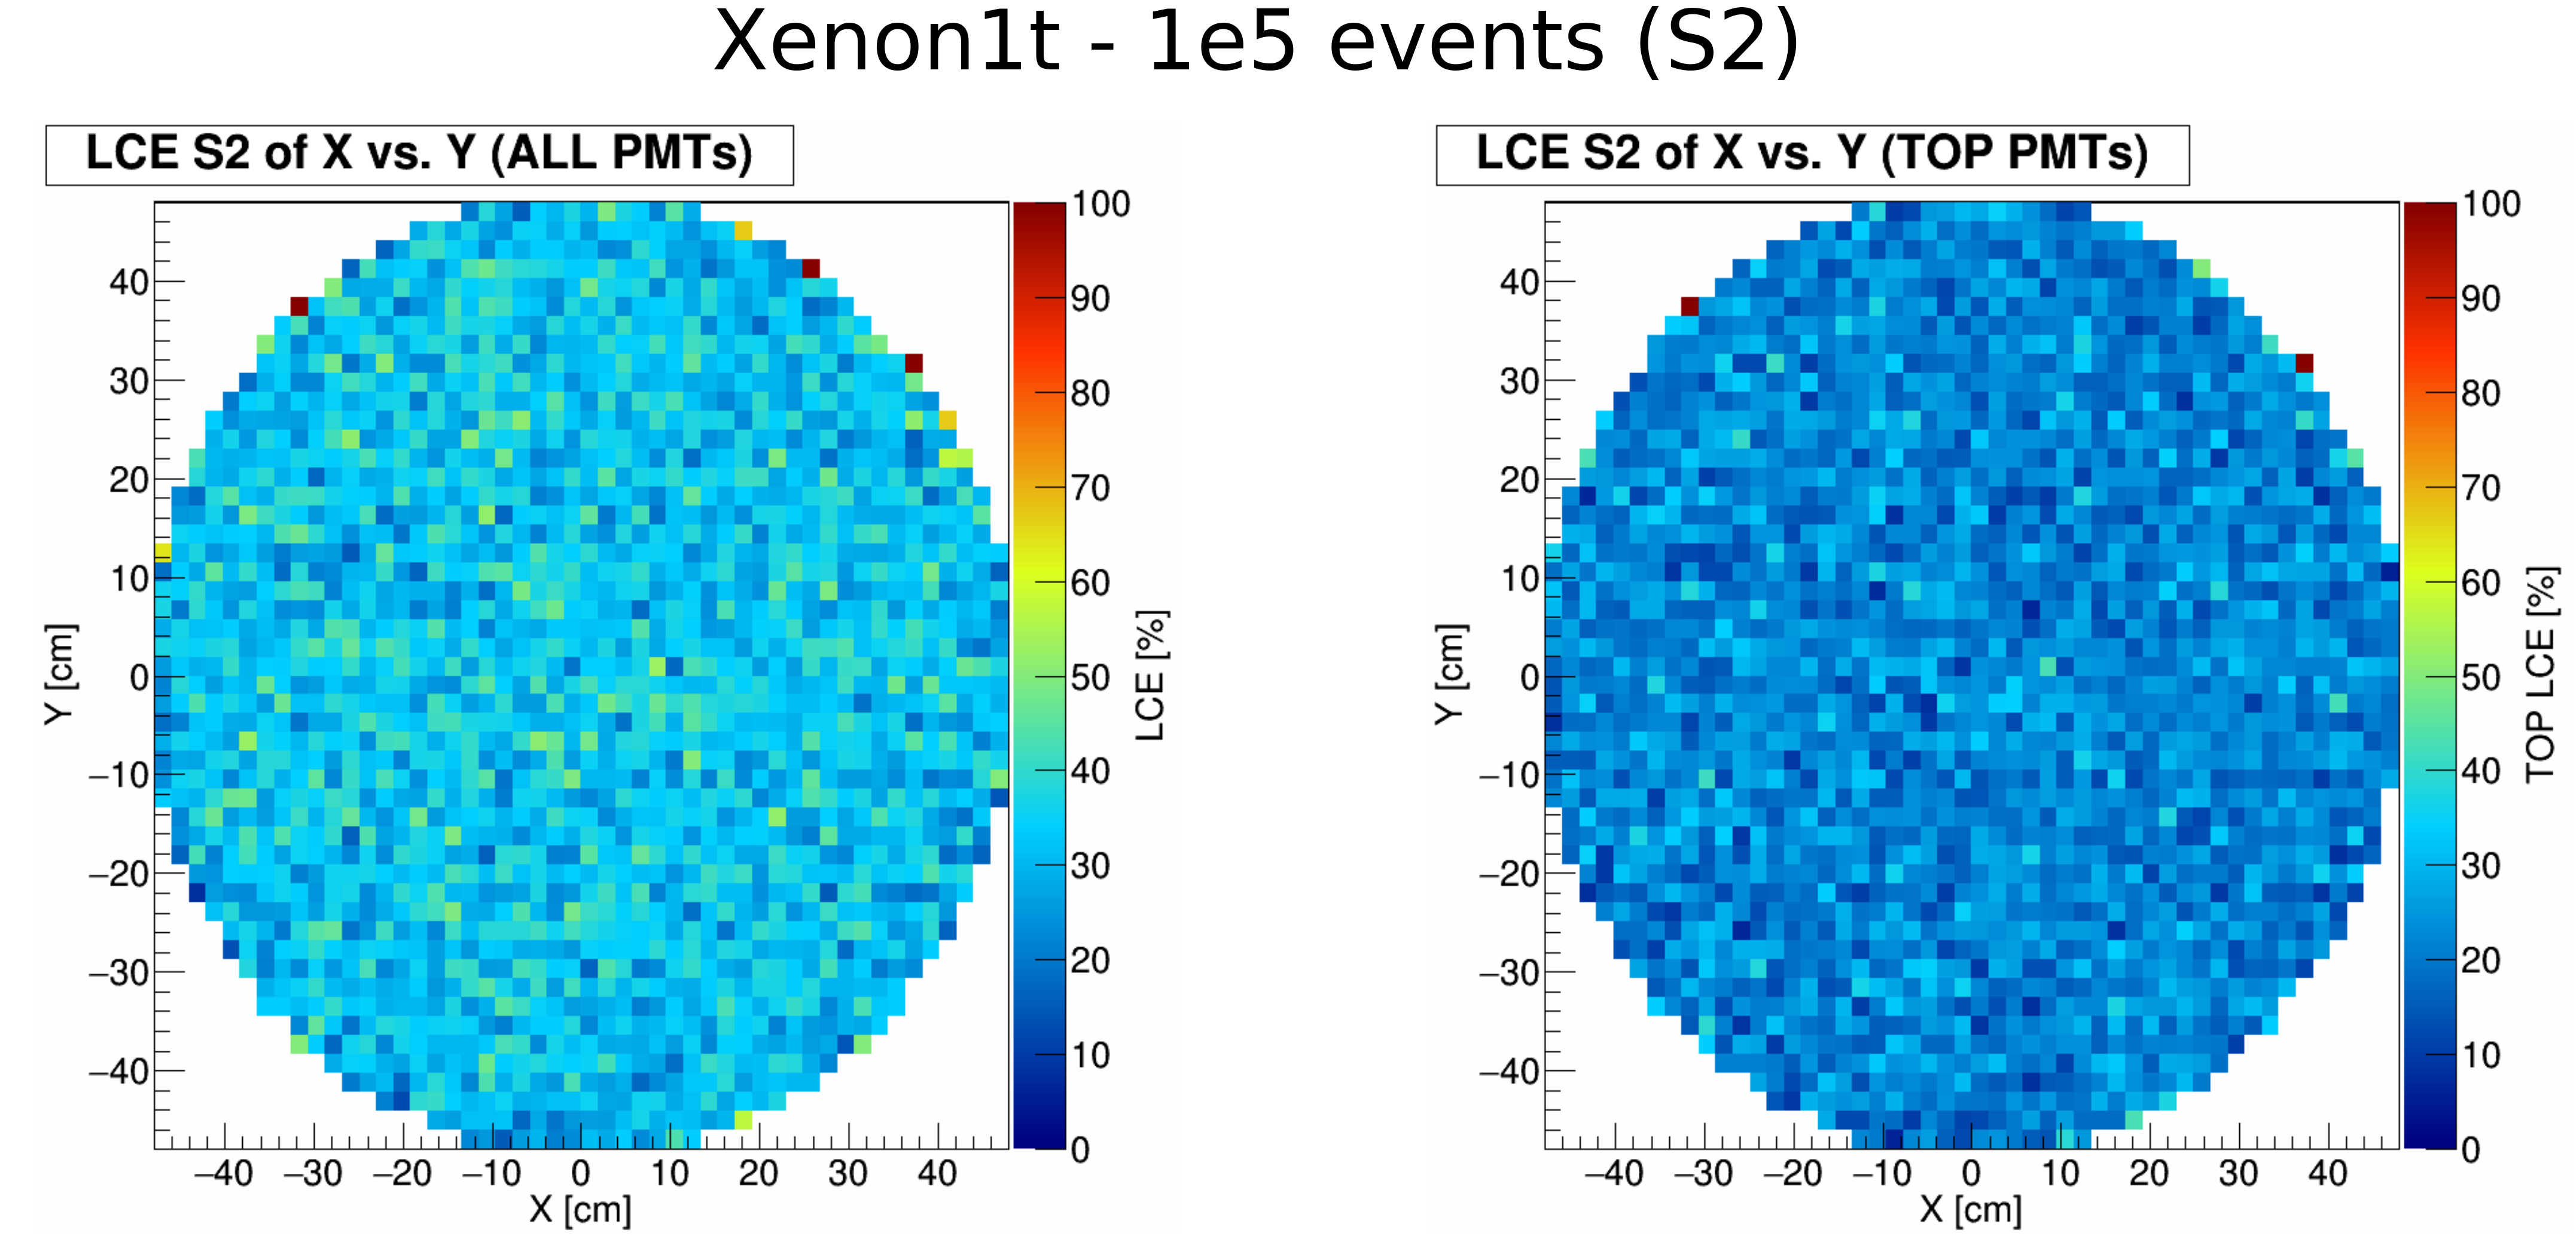

In [6]:
MC_file = './MC_Xe_TPC/MC_Xe_TPC_optPhot_S2_1e5.root'
bins = binning('26', '50', '22')
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_S2.cc++("'+MC_file+'",'+bins.z+','+bins.r+','+bins.rr+')')
show([MC_file[:-5]+'_S2_xy_LCE.png',MC_file[:-5]+'_S2_xy_LCE_top.png'], 'Xenon1t - 1e5 events (S2)')

In [7]:
S2_log = open(MC_file[:-5]+'_S2.dat', 'r')
S2_log_contents = S2_log.read()
print (S2_log_contents)
S2_log.close()

= reading datafile ===== single file =======================
 file: MC_Xe_TPC_optPhot_S2_1e5.root 100000 events 
= geometry parameters ======================================
binning: 26 50 22
chamber_minZ: -140
chamber_maxZ: 6
chamber_minRR: 0
chamber_maxRR: 3600
GXe_minZ: -96.7
GXe_maxZ: 0
GXe_minRR: 0
GXe_maxRR: 2294.41
LCE_min: 0
LCE_max: 50
= analyse ttree ============================================
generated events: 100000
Top PMT hits: 22046
All PMT hits: 32602
AFT: 0.676216



<hr><a id='parameter_variations'></a>
# Parameter variations

Plot parameter variations generated by the `processing` scripts in the top dir.

= reading datafiles ==== dir mode ==========================
= file: 0.1.6_S1_90_99_5000_10000_30_163_01.root 10000 events total. param: 90
= file: 0.1.6_S1_95_99_5000_10000_30_163_01.root 10000 events total. param: 95
= file: 0.1.6_S1_99_99_5000_10000_30_163_01.root 10000 events total. param: 99
= file: 0.1.6_S2_90_99_5000_10000_30_163_01.root 10000 events total. param: 90
= file: 0.1.6_S2_95_99_5000_10000_30_163_01.root 10000 events total. param: 95
= file: 0.1.6_S2_99_99_5000_10000_30_163_01.root 10000 events total. param: 99



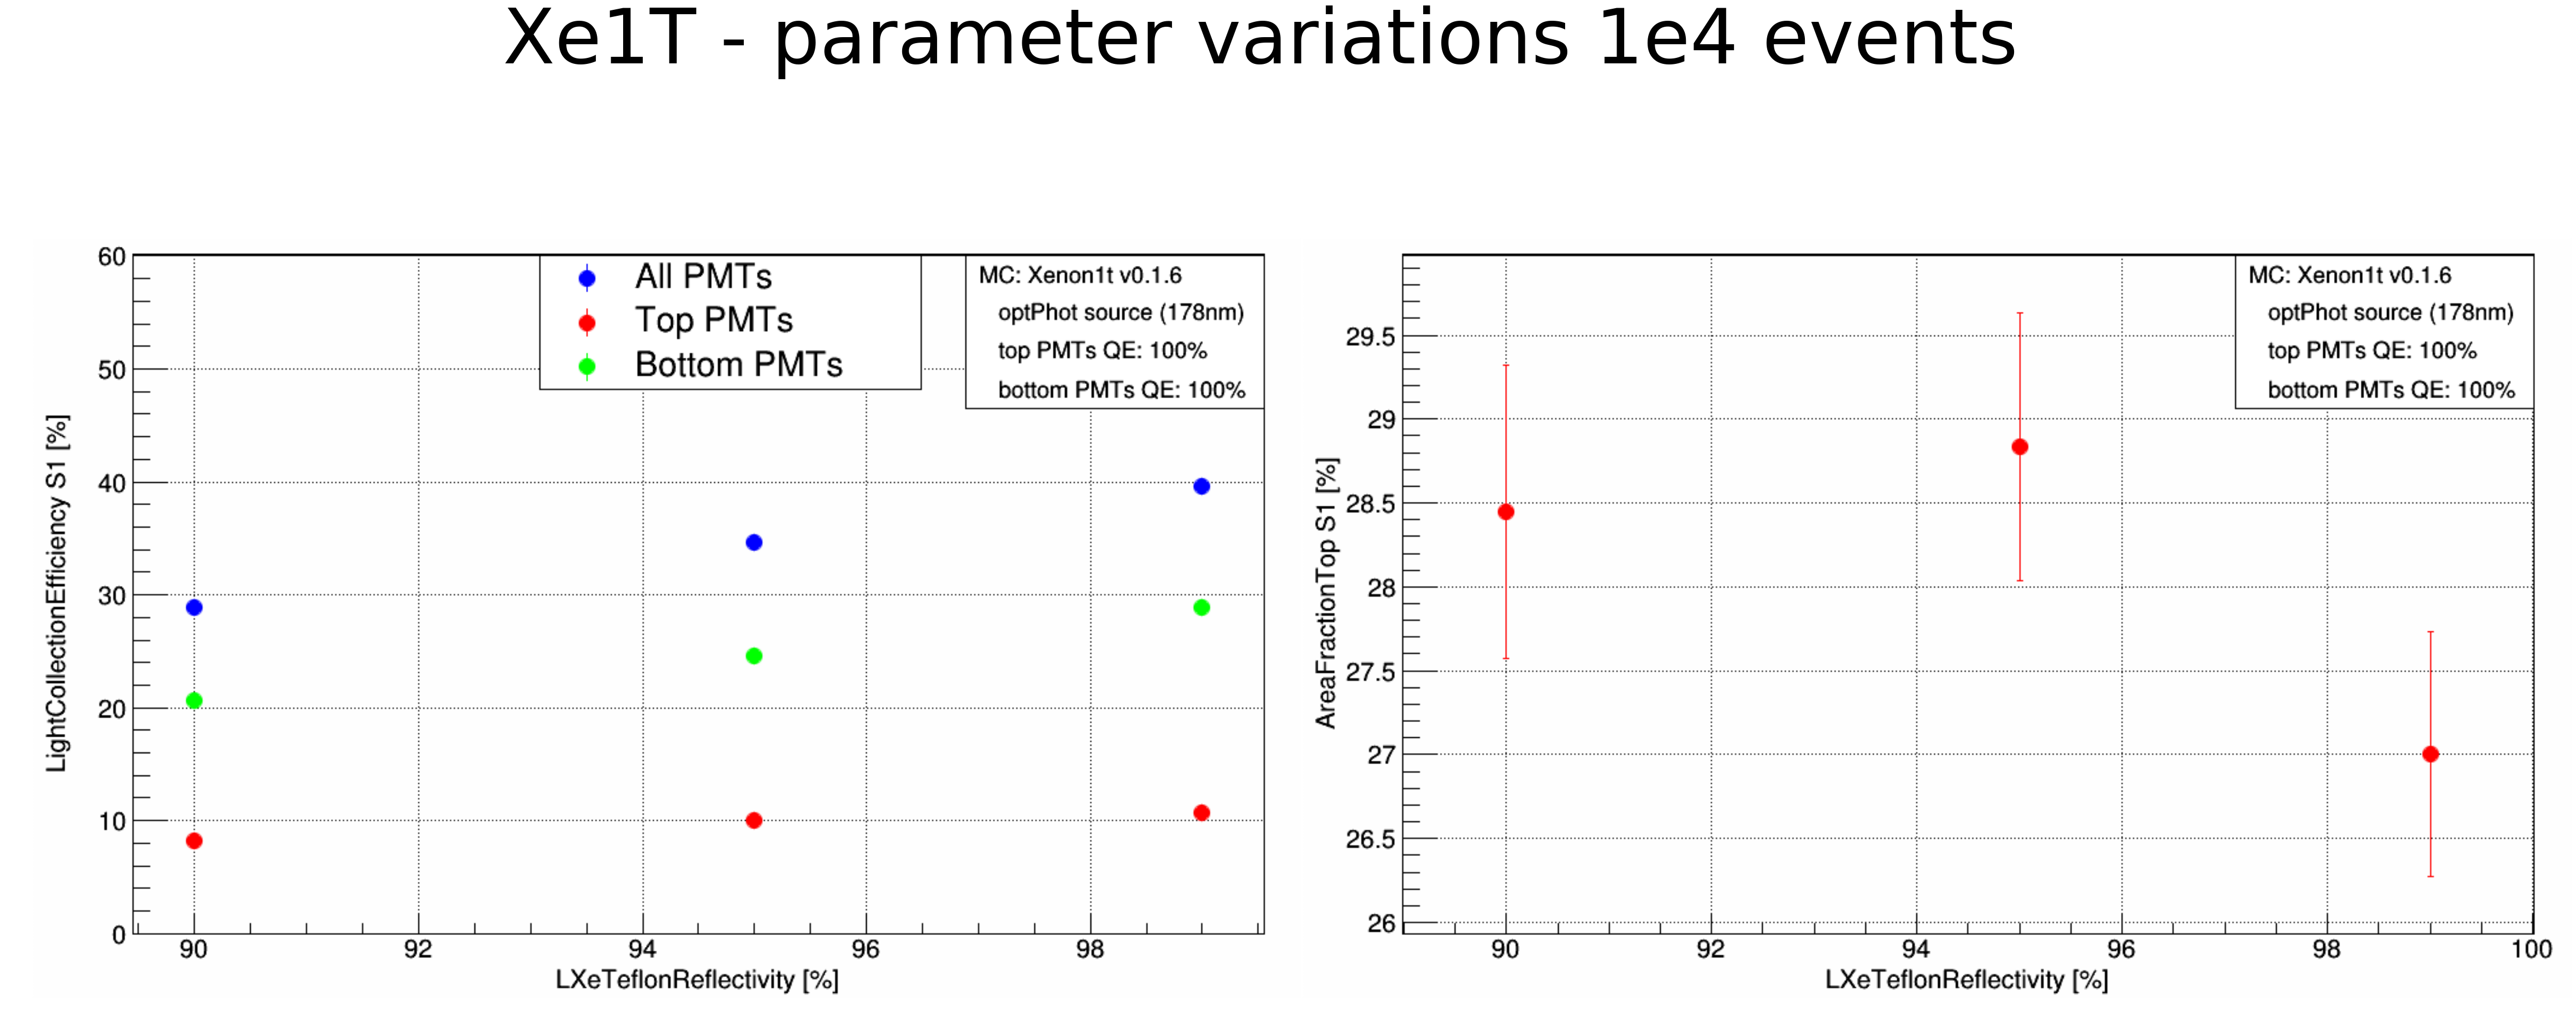

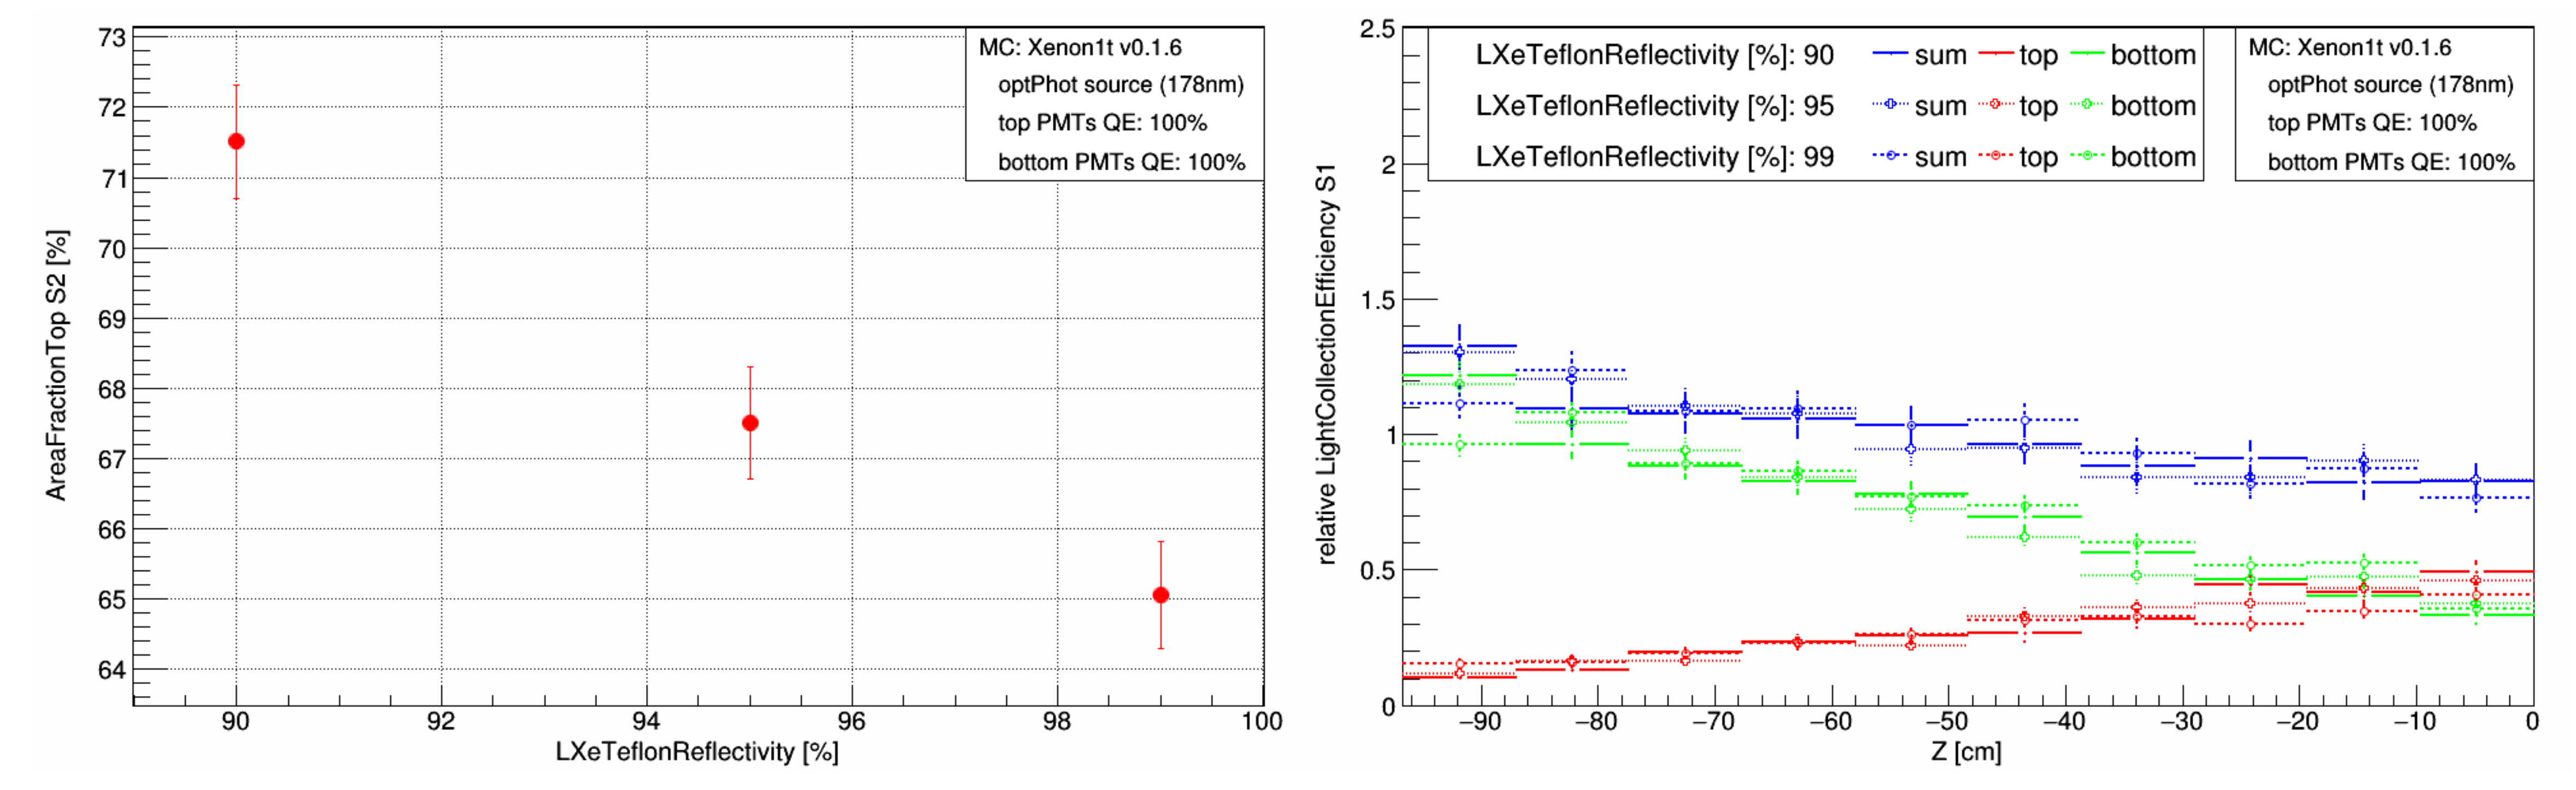

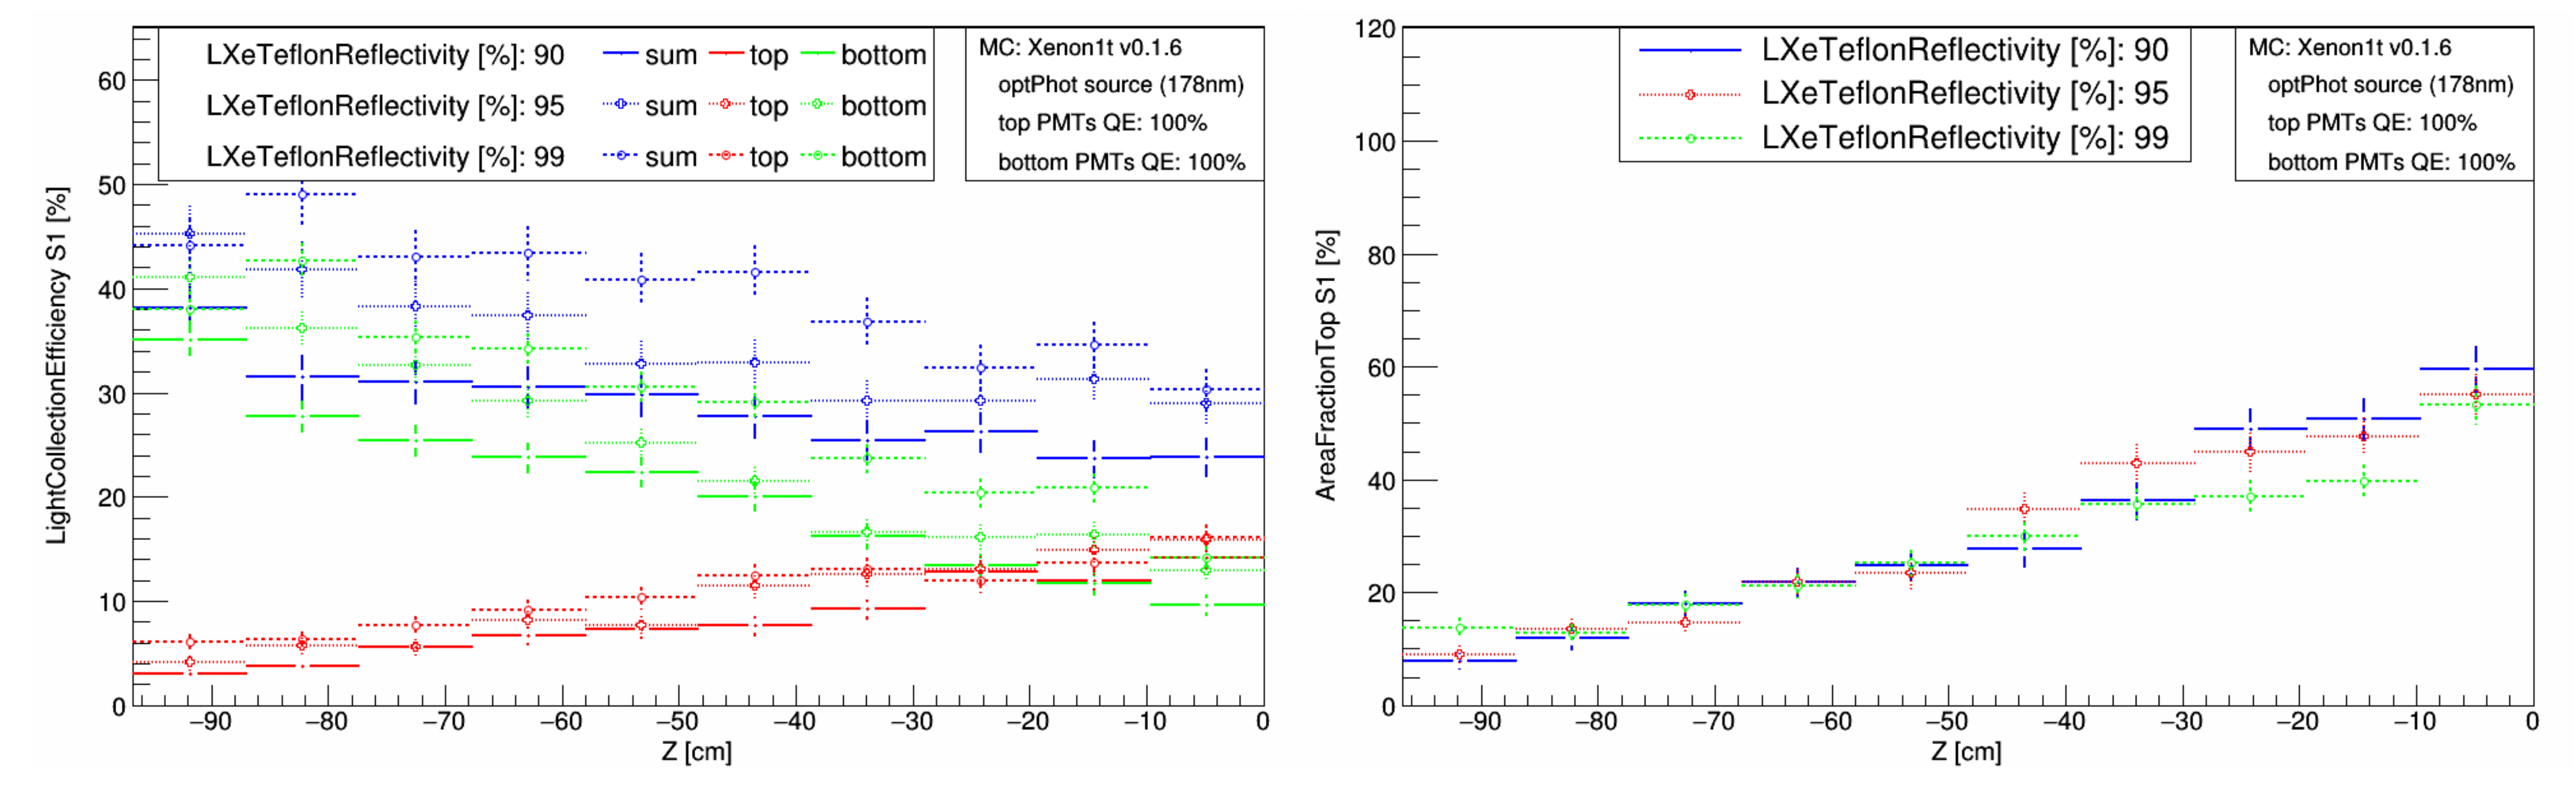

In [39]:
%%rootprint
MC_dir = './parameter_variations/'
MC_param = 'LXeTR'
bins_z = '10'
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_parameter_variations.cc++("'+MC_dir+'","'+MC_param+'",'+bins_z+')')
show([MC_dir+'paramvar_'+MC_param+'_LCE.png',
      MC_dir+'paramvar_'+MC_param+'_AFT.png'],'Xe1T - parameter variations 1e4 events')
show([MC_dir+'paramvar_'+MC_param+'_AFT_S2.png',
      MC_dir+'paramvar_'+MC_param+'_rLCEz.png'])
show([MC_dir+'paramvar_'+MC_param+'_LCEz.png',
      MC_dir+'paramvar_'+MC_param+'_AFTz.png'])

In [4]:
parameter_variation_log = open(MC_dir+'paramvar_'+MC_param+'.dat', 'r')
parameter_variation_log_contents = parameter_variation_log.read()
print (parameter_variation_log_contents)
parameter_variation_log.close()

= geometry parameters ======================================
parameter: LXeTR
binning: 10 
chamber_minZ: -140
chamber_maxZ: 6
chamber_minRR: 0
chamber_maxRR: 3600
LXe_minZ: -96.7
LXe_maxZ: 0
LXe_minRR: 0
LXe_maxRR: 2294.41
LCE_min: 0
LCE_max: 100
= reading datafiles ==== dir mode ==========================
= file: 0.1.6_S1_90_99_5000_10000_30_163_01.root 10000 events total. param: 90
generated events (LXe): 9252
detected events (LXe): 2668
Mean LCE LXe(detected/generated): 28.837
detected events (LXe TOP): 759
Mean LCE LXe(detected TOP/generated): 8.20363
AreaFractionTop LXe(detected TOP/detected): 28.4483
detected events (LXe BOT): 1909
Mean LCE LXe(detected Bot/generated): 20.6334
AreaFractionBot LXe(detected BOT/detected): 71.5517
= file: 0.1.6_S1_95_99_5000_10000_30_163_01.root 10000 events total. param: 95
generated events (LXe): 9246
detected events (LXe): 3201
Mean LCE LXe(detected/generated): 34.6204
detected events (LXe TOP): 923
Mean LCE LXe(detected TOP/generated): 9.9827
Ar

<hr><a id='data_maps'></a>
# data maps

For plotting the data maps used in the matching macro.

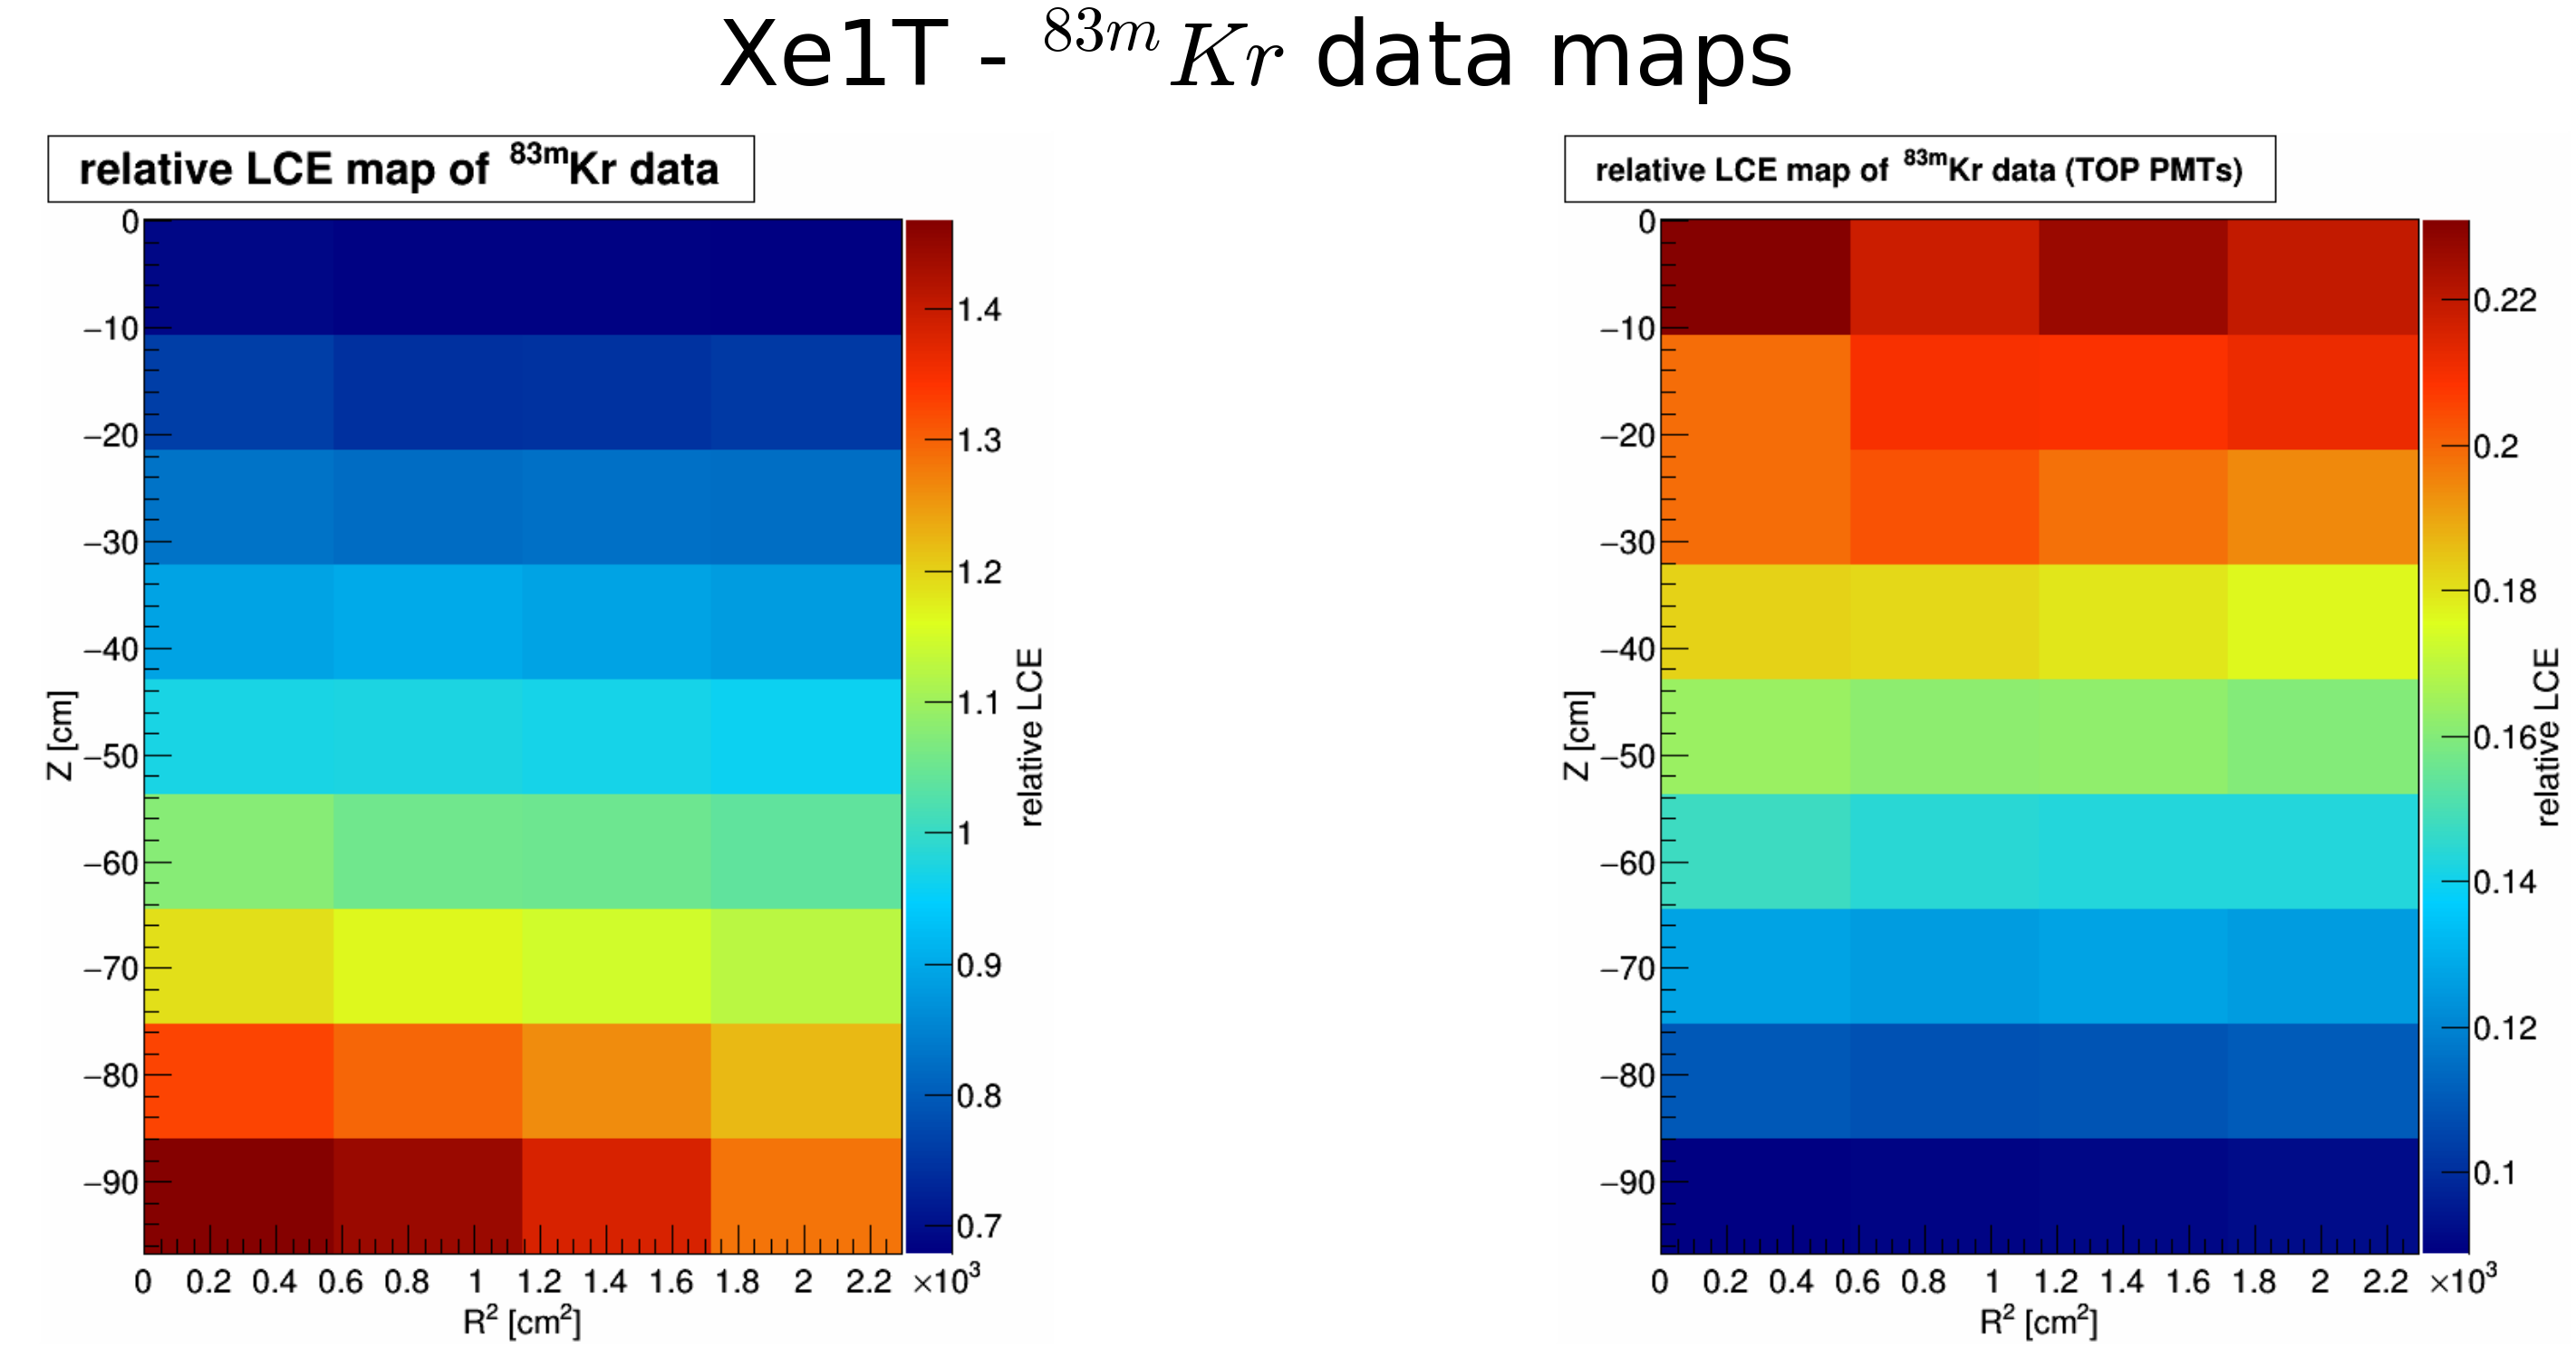

In [23]:
map_file = './data_maps/Xe_Kr83m.txt'
bins = binning('9', '4', '4')
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/data_maps.cc++("'+map_file+'",'+bins.z+','+bins.r+','+bins.rr+',"png")')
show([map_file[:-4]+'_map_rLCE.png',map_file[:-4]+'_map_rLCE_top.png'],'Xe1T - $^{83m}Kr$ data maps')

<hr><a id='comparison'></a>
# Comparison of MC vs. data map

| comparison | MC | data map |    
|----|----|----|  
| `*_AFTrr.png`           | `*_rrZ_MC_ly.png`          | `*_rrZ_Kr_ly.png`          |  
| `*_AFTz.png`            | `*_rrZ_MC_ly_top.png`      | `*_rrZ_Kr_ly_top.png`      |  
| `*_lyz.png`             | `*_rrZ_MC_ly_bottom.png`   | `*_rrZ_Kr_ly_bottom.png`   |  
| `*_rLCEz.png`           | `*_rrZ_MC_rLCE.png`        | `*_rrZ_Kr_rLCE.png`        |    
| `*_rrZ_ly.png`          | `*_rrZ_MC_rLCE_top.png`    | `*_rrZ_Kr_rLCE_top.png`    |  
| `*_rrZ_ly_top.png`      | `*_rrZ_MC_rLCE_bottom.png` | `*_rrZ_Kr_rLCE_bottom.png` |  
| `*_rrZ_ly_bottom.png`   |                            |                            |   
| `*_rrZ_rLCE.png`        |                            |                            |  
| `*_rrZ_rLCE_top.png`    |                            |                            |  
| `*_rrZ_rLCE_bottom.png` |                            |                            |  

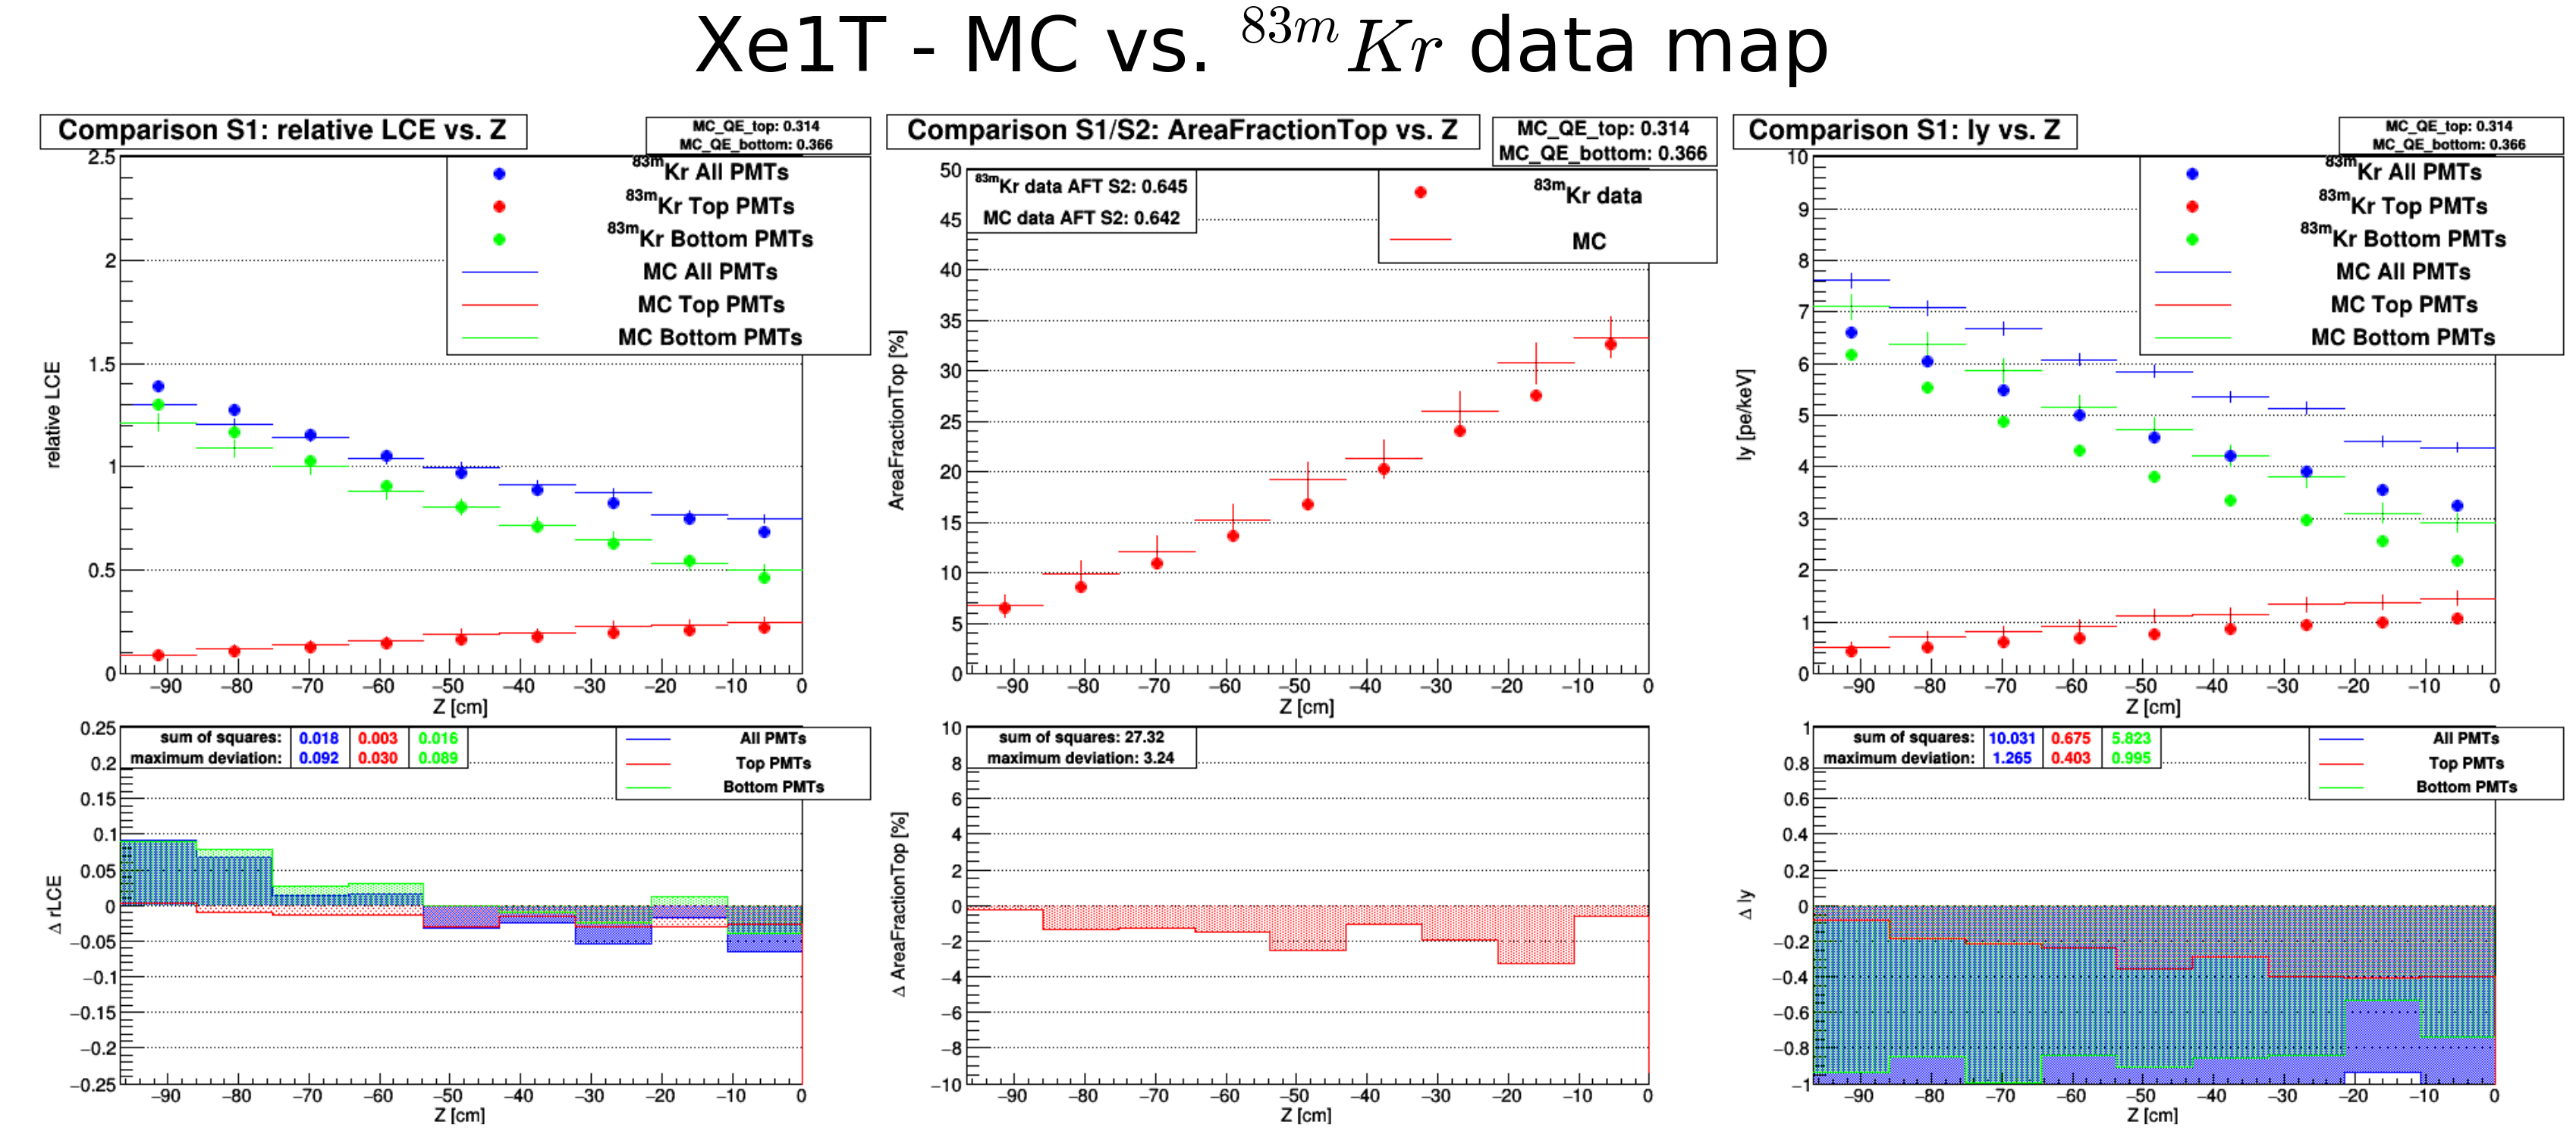

In [24]:
comparison_path = './comparison/'
map_file = 'Xe_Kr83m.txt'
MC_file = 'MC_Xe_TPC_optPhot_S1_1e5.root'
bins = binning('9', '4', '4')
theta_bins = '4 6 8 12'
data_AFT_S2 = '0.645'
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_comparison.cc++("'+comparison_path+map_file+'",'+data_AFT_S2+
                       ',"'+comparison_path+MC_file+'",'+bins.z+','+bins.r+','+bins.rr+',"'+theta_bins+'","png")')
show([comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_rLCEz.png',
      comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_AFTz.png',
      comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_lyz.png'],
     'Xe1T - MC vs. $^{83m}Kr$ data map')

<hr><a id='matching'></a>
# Matching MC vs. data maps 

1. Get a current data map and in the format:
```
z    t    r    zmid    tmid    rmid    ly    err_ly    ly_sigma    err_ly_sigma    ly_areaTop    err_ly_areaTop    ly_sigma_areaTop     err_ly_sigma_areaTop
```
1. Get MC simulations for every interesting parameter combination. Use the scripts in `processing` to generate them with the naming:
```
<VERSIONTAG>_<SIGNTYPE>_<LXeTR>_<GXeTR>_<LXeAbsL>_<GXeAbsL>_<LXeRSL>_<LXeRef>_<NUMBER>.root
```
1. Start the `optPhot_matching` script and let it work ..
1. Look at the output of the matcher and choose a "best" matching.
1. Plot the best matching `*.root` file against the data map.

In [22]:
MC_files = './MC_Xe_TPC_matching/'
map_file = './MC_Xe_TPC_matching/Xe_Kr83m.txt'
bins = binning('9', '4', '4')
theta_bins = '4 6 8 12'
data_AFT_S2 = '0.645'
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_matching.cc++("'+map_file+'",'+data_AFT_S2+
                       ',"'+MC_files+'",'+bins.z+','+bins.r+','+bins.rr+',"'+theta_bins+'","png")')

0

In [23]:
matching_log = MC_files+'matching_'+MC_files[2:-1]+'.dat'
!LC_ALL=C sort -k14 -g {matching_log} -o {matching_log+'_sorted.dat'}
matching_log = open(matching_log+'_sorted.dat', 'r')
matching_log_contents = matching_log.read()
print (matching_log_contents)
matching_log.close()

#VTag	STyp	LXeTR	GXeTR	LXeAbsL	GXeAbsL	LXeRSL	LXeRef	#	SOS_rLCE_S1	SOS_AFT_S1	SOS_ly_S1	SOS_AFT_S2	SOS_sum
0.1.6	S1	99	99	5000	10000	30	163	01	0.095252	431.345889	43.130367	0.030082	48.738283
0.1.6	S1	90	99	5000	10000	30	163	01	0.045806	944.333042	1.426399	0.037898	54.115150
0.1.6	S1	95	99	5000	10000	30	163	01	0.037175	968.946000	14.898834	0.004422	62.278508



**Note:** See above instruction on plotting comparisons!

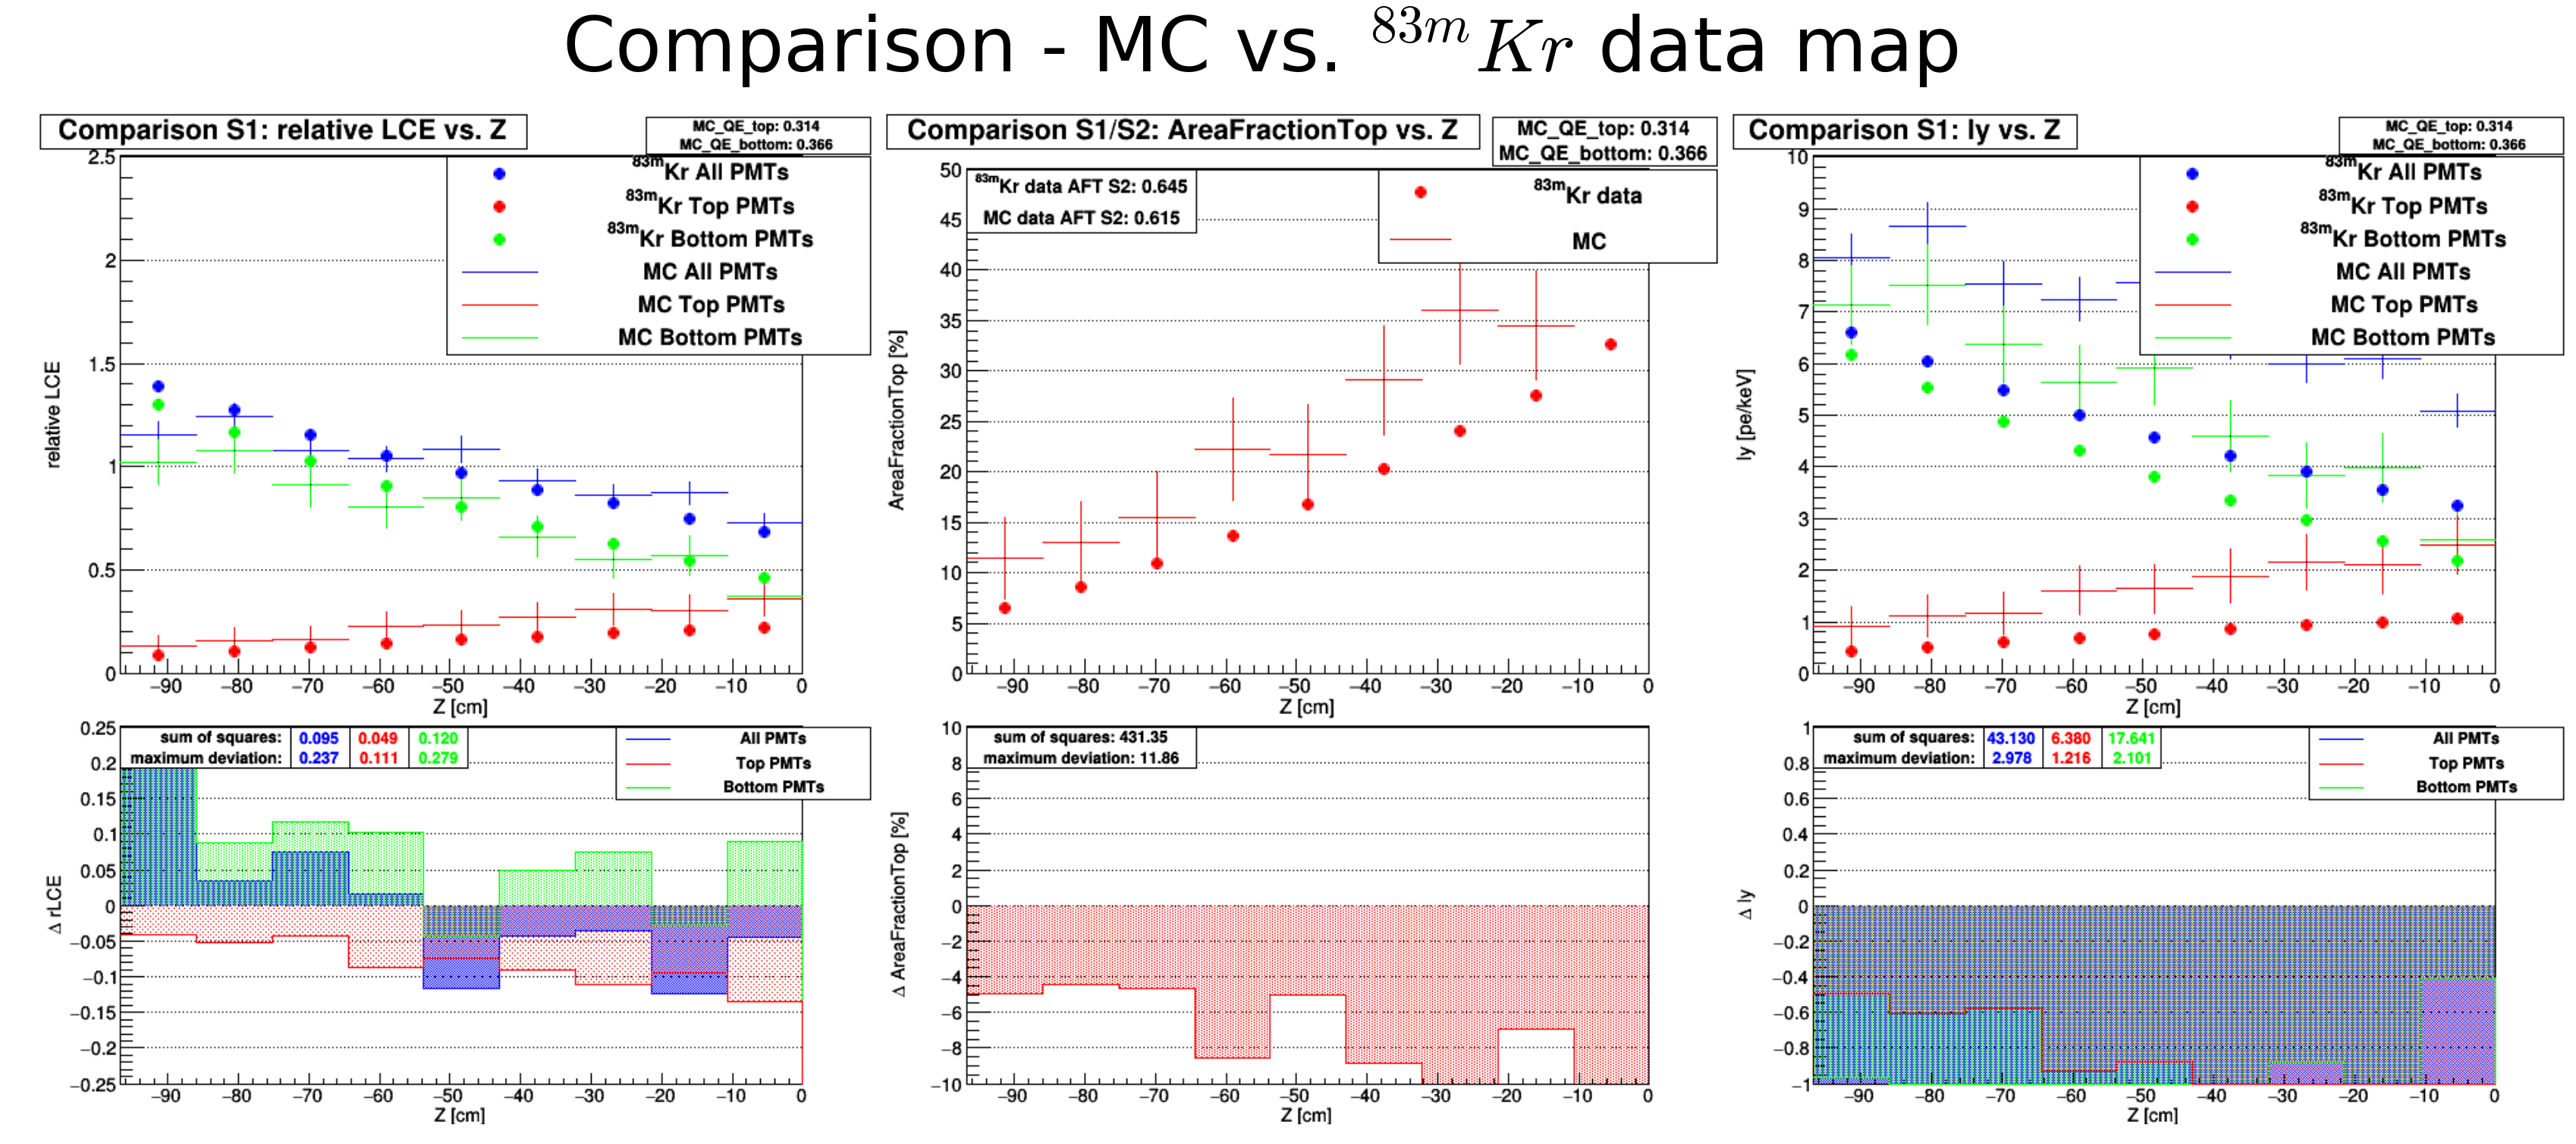

In [25]:
comparison_path = './MC_Xe_TPC_matching/'
map_file = 'Xe_Kr83m.txt'
MC_file = '0.1.6_S1_99_99_5000_10000_30_163_01.root'
bins = binning('9', '4', '4')
theta_bins = '4 6 8 12'
data_AFT_S2 = '0.645'
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/optPhot_comparison.cc++("'+comparison_path+map_file+'",'+data_AFT_S2+
                       ',"'+comparison_path+MC_file+'",'+bins.z+','+bins.r+','+bins.rr+',"'+theta_bins+'","png")')
show([comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_rLCEz.png',
      comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_AFTz.png',
      comparison_path+'comparison_'+MC_file[:-5]+'_vs_'+map_file[:-4]+'_lyz.png'],
     'Comparison - MC vs. $^{83m}Kr$ data map')

<hr><a id='calibration'></a>
# Calibration sources

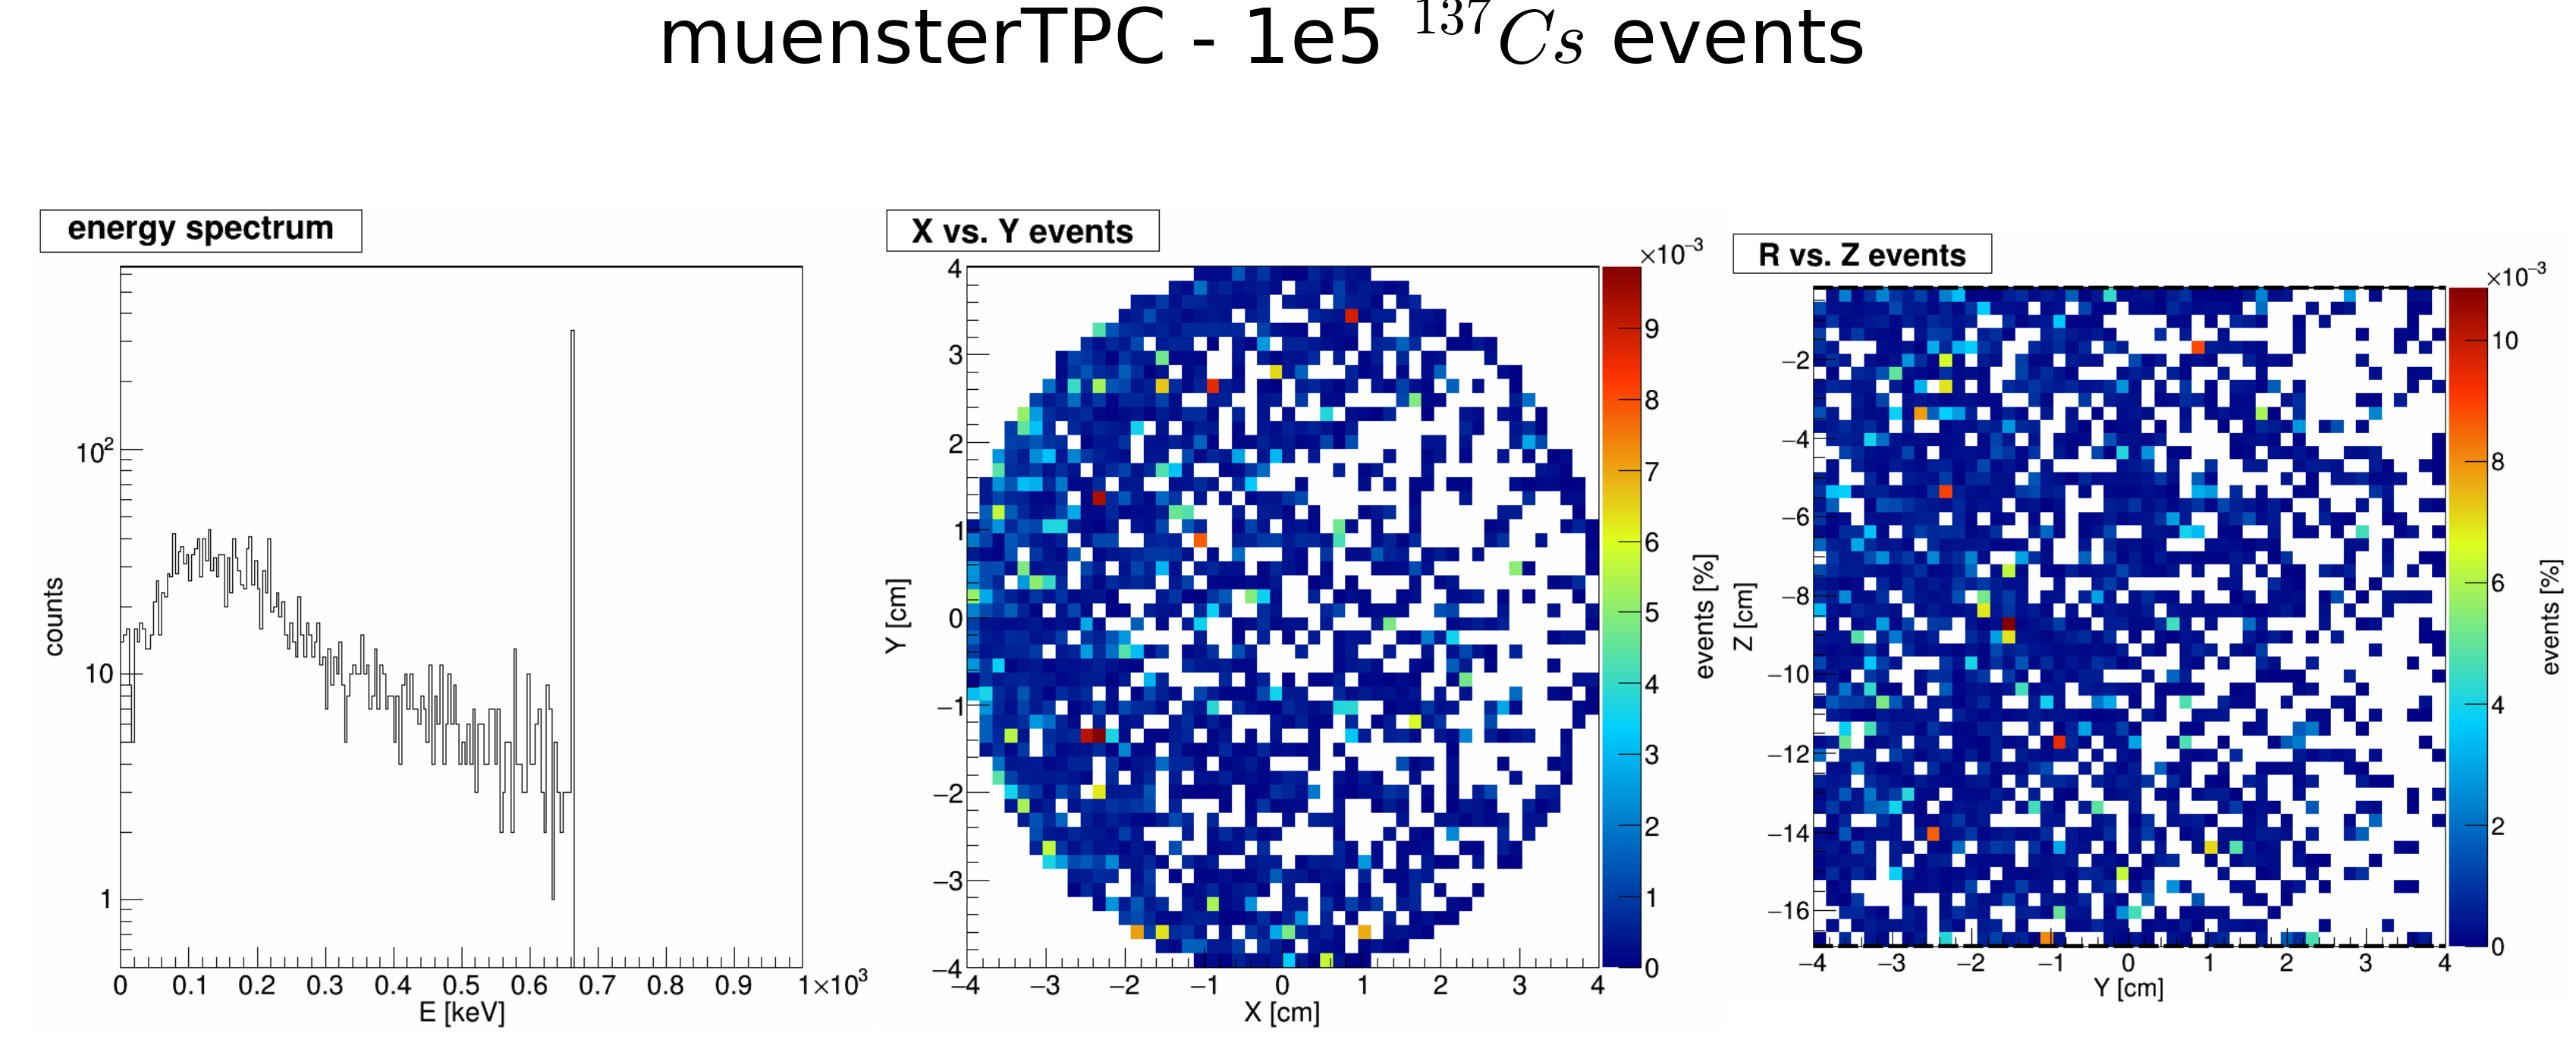

In [25]:
MC_file = './MC_MS_TPC/MC_MS_TPC_Cs137_1e5.root'
bins = binning('50', '50', '22')
ROOT.gROOT.ProcessLine('gROOT->Reset();')
ROOT.gROOT.ProcessLine('.x ../src/calibration_source.cc++("'+MC_file+'",'+bins.z+','+bins.r+','+bins.rr+',"png")')
show([MC_file[:-5]+'_calsource_spectrum.png',
      MC_file[:-5]+'_calsource_xy.png',
      MC_file[:-5]+'_calsource_yz.png',],
     'muensterTPC - 1e5 $^{137}Cs$ events')

In [ ]:
output_HTML(notebook_name)